In [152]:
import numpy as np
import scipy.stats as ss
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from time import time
from polyagamma import random_polyagamma
import jax
from jax import lax
import jax.numpy as jnp
from jax.scipy.stats import norm
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS


# IRT Model

$I$ multiple choice questions

$Y_{p, i} = 1$ is student $p \in \{1, \ldots, P\}$ has the correct answer on item $i \in [I]$.

$$Y_{p, i}|a, b, \theta \overset{\text{indep.}}{\sim} Bern(\frac{e^{a_i\theta_p + b_i}}{1 + e^{a_i\theta_p + b_i}})$$

$$a_i \overset{\text{i.i.d.}}{\sim} N(0, \sigma_a^2)$$

$$b_i \overset{\text{i.i.d.}}{\sim} N(0, \sigma_b^2)$$

$$\theta_p \sim N(0, 1)$$

Let $\sigma_a^2 = \sigma_b^2 = 100$, $\Psi = (a, b, \theta)$.

$$\pi(\Psi|y) \propto \exp(- \frac{1}{2\sigma_a^2} \|a\|^2 - \frac{1}{2\sigma_b^2}\|b\|^2 - \frac{1}{2}\|\theta\|^2 + \sum_{p, i} y_{p, i}(a_i\theta_p + b_i) - \log(1 + \exp(a_i\theta_p + b_i))$$

Equivalently, notice

$$\log\pi(\Psi | y) = \sum_p\sum_i \log p(y_{p, i}|a, b, \theta) + \log p(a_i) + \log p(b_i) + \log p(\theta_p)$$


With conditionals:

$$\log \pi(a_i| \cdot) = \sum_p\sum_i \log p(y_{p, i}|a, b, \theta) + \log p(a_i) $$
$$= P\sum_i\log p(a_i) + \sum_p\sum_i \log p(y_{p, i}|a, b, \theta)$$

$$\log \pi(b_i| \cdot) = \sum_p\sum_i \log p(y_{p, i}|a, b, \theta) + \log p(b_i)$$

$$= P\sum_i\log p(b_i) + \sum_p\sum_i \log p(y_{p, i}|a, b, \theta)$$

$$\log \pi(\theta_p| \cdot) = \sum_p\sum_i \log p(y_{p, i}|a, b, \theta) + \log p(\theta_p)$$

$$= I\sum_p \log p(\theta_p) + \sum_p\sum_i \log p(y_{p, i}|a, b, \theta)$$

Unfortunately, none of these have a closed form.

## Naive Metropolis-Hastings

### Fully Metropolis-Gibbs

In [86]:
variance = 100

sa = jnp.sqrt(variance)
sb = jnp.sqrt(variance)

def log_joint(a, b, t, Y):
    la = jnp.sum(dist.Normal(0, sa).log_prob(a))
    lb = jnp.sum(dist.Normal(0, sb).log_prob(b))
    lt = jnp.sum(dist.Normal(0, 1).log_prob(t))

    pi_val = jnp.outer(t, a) + b[None, :]
    
    lY = jnp.sum(dist.Bernoulli(logits=pi_val).log_prob(Y))

    return la + lb + lt + lY

def mh_naive1(Y, n_iter = 2000, prop_sd_a = 0.5, prop_sd_b = 0.5, prop_sd_t = 0.2, a_init = None, b_init = None, t_init = None):

    Y = jnp.asarray(Y)
    P, I = Y.shape

    if a_init is None:
        a = jnp.zeros(I)
    else:
        a = jnp.asarray(a_init)
    if b_init is None:
        b = jnp.zeros(I)
    else:
        b = jnp.asarray(b_init)
    if t_init is None:
        t = jnp.zeros(P)
    else:
        t = jnp.asarray(t_init)

    trace_a = np.zeros((n_iter, I), dtype=float)
    trace_b = np.zeros((n_iter, I), dtype=float)
    trace_t = np.zeros((n_iter, P), dtype=float)

    acc_a = np.zeros(I, dtype=int)
    acc_b = np.zeros(I, dtype=int)
    acc_t = np.zeros(P, dtype=int)

    key = jax.random.PRNGKey(0)

    curr_lp = float(log_joint(a, b, t, Y))

    for it in range(n_iter):
        for i in range(I):
            key, subkey = jax.random.split(key)
            proposal = a[i] + prop_sd_a * jax.random.normal(subkey)
            a_prop = a.at[i].set(proposal)
            lp_prop = float(log_joint(a_prop, b, t, Y))
            log_alpha = lp_prop - curr_lp
            key, subkey = jax.random.split(key)

            if jnp.log(jax.random.uniform(subkey)) < log_alpha:
                a = a_prop
                curr_lp = lp_prop
                acc_a[i] += 1

        for i in range(I):
            key, subkey = jax.random.split(key)
            proposal = b[i] + prop_sd_b * jax.random.normal(subkey)
            b_prop = b.at[i].set(proposal)
            lp_prop = float(log_joint(a, b_prop, t, Y))
            log_alpha = lp_prop - curr_lp
            key, subkey = jax.random.split(key)
            
            if jnp.log(jax.random.uniform(subkey)) < log_alpha:
                b = b_prop
                curr_lp = lp_prop
                acc_b[i] += 1

        for p in range(P):
            key, subkey = jax.random.split(key)
            proposal = t[p] + prop_sd_t * jax.random.normal(subkey)
            t_prop = t.at[p].set(proposal)
            lp_prop = float(log_joint(a, b, t_prop, Y))
            log_alpha = lp_prop - curr_lp
            key, subkey = jax.random.split(key)
            
            if jnp.log(jax.random.uniform(subkey)) < log_alpha:
                t = t_prop
                curr_lp = lp_prop
                acc_t[p] += 1

        trace_a[it, :] = np.array(a)
        trace_b[it, :] = np.array(b)
        trace_t[it, :] = np.array(t)

    traces = {'a': trace_a, 'b': trace_b, 't': trace_t}
    acc_rates = {'a': acc_a / n_iter, 'b': acc_b / n_iter, 't': acc_t / n_iter}
    return traces, acc_rates


MH sampler runtime: 80.80 seconds
mean acc a: 0.9808
mean acc b: 0.9775
mean acc theta: 0.9206
a_hat[:5]: [-0.44988185  1.06525001 -0.12879305  0.14655148  0.99062602]
b_hat[:5]: [-1.42350594  0.20843712 -0.97825471 -0.80423196 -1.11911471]
theta_hat[:5]: [-0.606692    0.43974991  0.74563672 -0.73149605 -0.32949547]

Differences (posterior mean - true value):
a_diff[:5]: [-1.07561207  0.69735487 -1.2692157  -0.45834864  1.02629539]
b_diff[:5]: [-0.80023148  0.16711114  1.34677607 -0.5854403   0.12679624]
theta_diff[:5]: [-0.47815734 -0.92671356  1.41083139 -1.08300612 -1.23296565]

Summary of absolute differences:
Mean absolute error a: 1.0614460571115525
Mean absolute error b: 0.47906306815908967
Mean absolute error theta: 0.9115406653200742
Max absolute error a: 2.7393640888427533
Max absolute error b: 1.3467760696269897
Max absolute error theta: 2.693472260999139


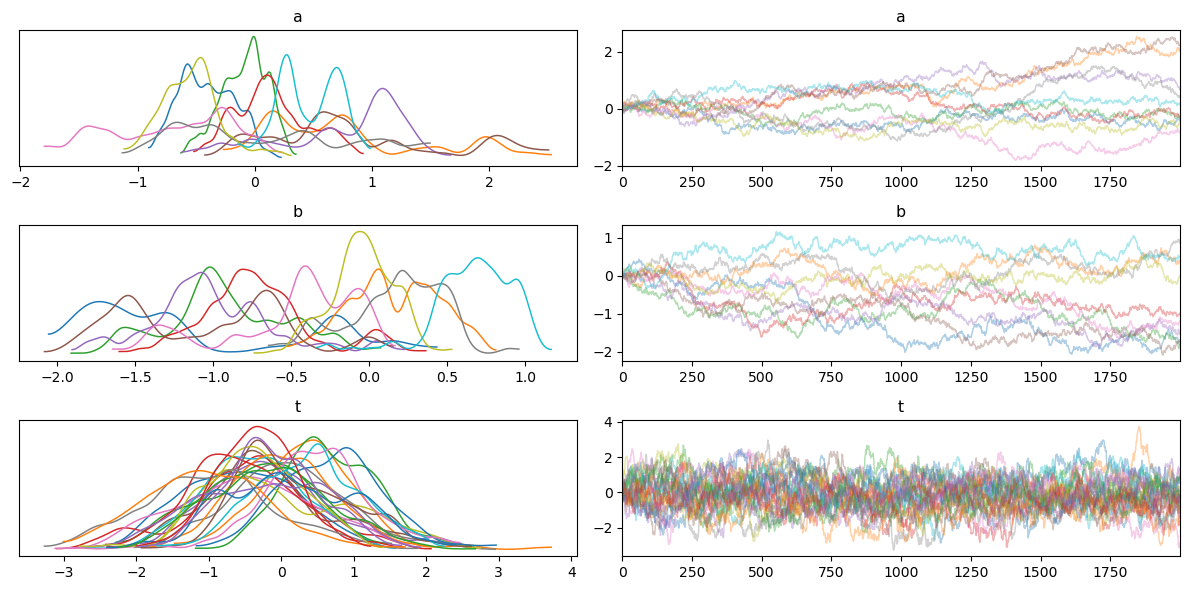

In [87]:
rng = np.random.default_rng(0)
P, I = 25, 10
true_a = rng.normal(0.5, 1.0, size=I)
true_b = rng.normal(0.0, 1.0, size=I)
true_theta = rng.normal(0.0, 1.0, size=P)
lin = np.outer(true_theta, true_a) + true_b[None, :]
prob = 1.0 / (1.0 + np.exp(-lin))
Y = (rng.uniform(size=(P, I)) < prob).astype(np.int32)

start_time = time()

traces, acc = mh_naive1(jnp.array(Y), n_iter=2000, prop_sd_a=0.03, prop_sd_b=0.03, prop_sd_t=0.18)

end_time = time()

print(f"MH sampler runtime: {end_time - start_time:.2f} seconds")

print("mean acc a:", acc['a'].mean())
print("mean acc b:", acc['b'].mean())
print("mean acc theta:", acc['t'].mean())

# Posterior means after burn-in
burn = 500
a_hat = traces['a'][burn:].mean(axis=0)
b_hat = traces['b'][burn:].mean(axis=0)
theta_hat = traces['t'][burn:].mean(axis=0)

# Print first few posterior means
print("a_hat[:5]:", a_hat[:5])
print("b_hat[:5]:", b_hat[:5])
print("theta_hat[:5]:", theta_hat[:5])

# --- Compare to true values ---
a_diff = a_hat - true_a
b_diff = b_hat - true_b
theta_diff = theta_hat - true_theta

print("\nDifferences (posterior mean - true value):")
print("a_diff[:5]:", a_diff[:5])
print("b_diff[:5]:", b_diff[:5])
print("theta_diff[:5]:", theta_diff[:5])

# Optional: compute summary metrics
print("\nSummary of absolute differences:")
print("Mean absolute error a:", np.mean(np.abs(a_diff)))
print("Mean absolute error b:", np.mean(np.abs(b_diff)))
print("Mean absolute error theta:", np.mean(np.abs(theta_diff)))
print("Max absolute error a:", np.max(np.abs(a_diff)))
print("Max absolute error b:", np.max(np.abs(b_diff)))
print("Max absolute error theta:", np.max(np.abs(theta_diff)))

# --- ArviZ visualization (optional) ---
idata = az.from_dict(posterior={
    "a": traces['a'][None, :, :],  # shape (chain=1, draws, I)
    "b": traces['b'][None, :, :],
    "t": traces['t'][None, :, :]
})

az.plot_trace(idata, var_names=["a", "b", "t"])
plt.tight_layout()
plt.show()


### Parameter Blocked Metropolis-Gibbs

In [88]:
def mh_naive2(Y, n_iter = 2000, prop_sd_a = 0.5, prop_sd_b = 0.5, prop_sd_t = 0.2, a_init = None, b_init = None, t_init = None):

    Y = jnp.asarray(Y)
    P, I = Y.shape

    if a_init is None:
        a = jnp.zeros(I)
    else:
        a = jnp.asarray(a_init)
    if b_init is None:
        b = jnp.zeros(I)
    else:
        b = jnp.asarray(b_init)
    if t_init is None:
        t = jnp.zeros(P)
    else:
        t = jnp.asarray(t_init)

    trace_a = np.zeros((n_iter, I), dtype=float)
    trace_b = np.zeros((n_iter, I), dtype=float)
    trace_t = np.zeros((n_iter, P), dtype=float)

    acc_a = 0
    acc_b = 0
    acc_t = 0

    key = jax.random.PRNGKey(0)

    curr_lp = float(log_joint(a, b, t, Y))

    for it in range(n_iter):
        key, subkey = jax.random.split(key)
        a_prop = a + prop_sd_a * jax.random.normal(subkey, shape = a.shape)
        lp_prop = float(log_joint(a_prop, b, t, Y))
        log_alpha = lp_prop - curr_lp
        key, subkey = jax.random.split(key)

        if jnp.log(jax.random.uniform(subkey)) < log_alpha:
            a = a_prop
            curr_lp = lp_prop
            acc_a += 1

        key, subkey = jax.random.split(key)
        b_prop = b + prop_sd_b * jax.random.normal(subkey, shape = b.shape)
        lp_prop = float(log_joint(a, b_prop, t, Y))
        log_alpha = lp_prop - curr_lp
        key, subkey = jax.random.split(key)
        
        if jnp.log(jax.random.uniform(subkey)) < log_alpha:
            b = b_prop
            curr_lp = lp_prop
            acc_b += 1

        key, subkey = jax.random.split(key)
        t_prop = t + prop_sd_t * jax.random.normal(subkey, shape = t.shape)
        lp_prop = float(log_joint(a, b, t_prop, Y))
        log_alpha = lp_prop - curr_lp
        key, subkey = jax.random.split(key)
        
        if jnp.log(jax.random.uniform(subkey)) < log_alpha:
            t = t_prop
            curr_lp = lp_prop
            acc_t += 1

        trace_a[it, :] = np.array(a)
        trace_b[it, :] = np.array(b)
        trace_t[it, :] = np.array(t)

    traces = {'a': trace_a, 'b': trace_b, 't': trace_t}
    acc_rates = {'a': acc_a / n_iter, 'b': acc_b / n_iter, 't': acc_t / n_iter}
    return traces, acc_rates


MH sampler runtime: 3.88 seconds
acc a: 0.936
acc b: 0.9075
acc theta: 0.4835
a_hat[:5]: [ 0.40186936 -1.51334123  0.06084418  0.93283641 -0.50996656]
b_hat[:5]: [-1.07198745 -0.29508484 -1.35834949 -0.9286199  -0.60953454]
theta_hat[:5]: [-0.98147741 -0.66141766 -0.70671261 -0.23382288  0.72950696]

Differences (posterior mean - true value):
a_diff[:5]: [-0.22386086 -1.88123636 -1.07957848  0.32793629 -0.47429718]
b_diff[:5]: [-0.44871299 -0.33641082  0.96668129 -0.70982824  0.63637641]
theta_diff[:5]: [-0.85294275 -2.02788113 -0.04151794 -0.58533295 -0.17396322]

Summary of absolute differences:
Mean absolute error a: 1.1908747119826497
Mean absolute error b: 0.528439689061393
Mean absolute error theta: 0.8487467875024126
Max absolute error a: 3.2474911747569677
Max absolute error b: 0.9666812873341468
Max absolute error theta: 2.02788113237426


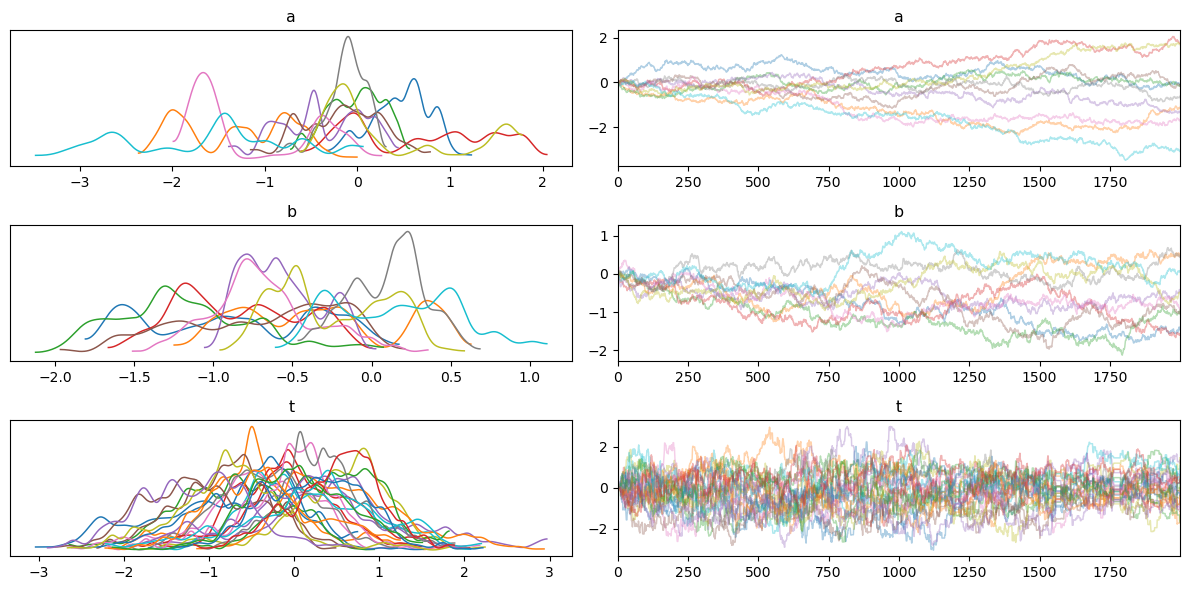

In [89]:
rng = np.random.default_rng(0)
P, I = 25, 10
true_a = rng.normal(0.5, 1.0, size=I)
true_b = rng.normal(0.0, 1.0, size=I)
true_theta = rng.normal(0.0, 1.0, size=P)
lin = np.outer(true_theta, true_a) + true_b[None, :]
prob = 1.0 / (1.0 + np.exp(-lin))
Y = (rng.uniform(size=(P, I)) < prob).astype(np.int32)

start_time = time()

traces, acc = mh_naive2(jnp.array(Y), n_iter=2000, prop_sd_a=0.03, prop_sd_b=0.03, prop_sd_t=0.18)

end_time = time()

print(f"MH sampler runtime: {end_time - start_time:.2f} seconds")

print("acc a:", acc['a'])
print("acc b:", acc['b'])
print("acc theta:", acc['t'])

# Posterior means after burn-in
burn = 500
a_hat = traces['a'][burn:].mean(axis=0)
b_hat = traces['b'][burn:].mean(axis=0)
theta_hat = traces['t'][burn:].mean(axis=0)

# Print first few posterior means
print("a_hat[:5]:", a_hat[:5])
print("b_hat[:5]:", b_hat[:5])
print("theta_hat[:5]:", theta_hat[:5])

# --- Compare to true values ---
a_diff = a_hat - true_a
b_diff = b_hat - true_b
theta_diff = theta_hat - true_theta

print("\nDifferences (posterior mean - true value):")
print("a_diff[:5]:", a_diff[:5])
print("b_diff[:5]:", b_diff[:5])
print("theta_diff[:5]:", theta_diff[:5])

# Optional: compute summary metrics
print("\nSummary of absolute differences:")
print("Mean absolute error a:", np.mean(np.abs(a_diff)))
print("Mean absolute error b:", np.mean(np.abs(b_diff)))
print("Mean absolute error theta:", np.mean(np.abs(theta_diff)))
print("Max absolute error a:", np.max(np.abs(a_diff)))
print("Max absolute error b:", np.max(np.abs(b_diff)))
print("Max absolute error theta:", np.max(np.abs(theta_diff)))

# --- ArviZ visualization (optional) ---
idata = az.from_dict(posterior={
    "a": traces['a'][None, :, :],  # shape (chain=1, draws, I)
    "b": traces['b'][None, :, :],
    "t": traces['t'][None, :, :]
})

az.plot_trace(idata, var_names=["a", "b", "t"])
plt.tight_layout()
plt.show()


### Fully Metropolis-Gibbs

In [90]:
variance = 100.0
sa = jnp.sqrt(variance)
sb = jnp.sqrt(variance)

def log_joint(a, b, theta, Y):
    la = jnp.sum(dist.Normal(0., sa).log_prob(a))
    lb = jnp.sum(dist.Normal(0., sb).log_prob(b))
    lt = jnp.sum(dist.Normal(0., 1.).log_prob(theta))
    logits = jnp.outer(theta, a) + b[None, :]
    lY = jnp.sum(dist.Bernoulli(logits=logits).log_prob(Y))
    return la + lb + lt + lY

def update_a_index(i, carry):
    # carry: (key, a, b, theta, curr_lp, acc_a, acc_b, acc_theta)
    key, a, b, theta, curr_lp, acc_a, acc_b, acc_theta = carry
    key, sub = jax.random.split(key)
    prop = a[i] + prop_sd_a * jax.random.normal(sub)
    a_prop = a.at[i].set(prop)
    lp_prop = log_joint(a_prop, b, theta, Y_global)
    key, sub2 = jax.random.split(key)
    accept = (jnp.log(jax.random.uniform(sub2)) < (lp_prop - curr_lp))
    a = jax.lax.cond(accept, lambda _: a_prop, lambda _: a, None)
    curr_lp = jax.lax.cond(accept, lambda _: lp_prop, lambda _: curr_lp, None)
    acc_a = acc_a.at[i].add(jnp.where(accept, 1, 0))
    return (key, a, b, theta, curr_lp, acc_a, acc_b, acc_theta)

def update_b_index(i, carry):
    key, a, b, theta, curr_lp, acc_a, acc_b, acc_theta = carry
    key, sub = jax.random.split(key)
    prop = b[i] + prop_sd_b * jax.random.normal(sub)
    b_prop = b.at[i].set(prop)
    lp_prop = log_joint(a, b_prop, theta, Y_global)
    key, sub2 = jax.random.split(key)
    accept = (jnp.log(jax.random.uniform(sub2)) < (lp_prop - curr_lp))
    b = jax.lax.cond(accept, lambda _: b_prop, lambda _: b, None)
    curr_lp = jax.lax.cond(accept, lambda _: lp_prop, lambda _: curr_lp, None)
    acc_b = acc_b.at[i].add(jnp.where(accept, 1, 0))
    return (key, a, b, theta, curr_lp, acc_a, acc_b, acc_theta)

def update_theta_index(p, carry):
    key, a, b, theta, curr_lp, acc_a, acc_b, acc_theta = carry
    key, sub = jax.random.split(key)
    prop = theta[p] + prop_sd_theta * jax.random.normal(sub)
    theta_prop = theta.at[p].set(prop)
    lp_prop = log_joint(a, b, theta_prop, Y_global)
    key, sub2 = jax.random.split(key)
    accept = (jnp.log(jax.random.uniform(sub2)) < (lp_prop - curr_lp))
    theta = jax.lax.cond(accept, lambda _: theta_prop, lambda _: theta, None)
    curr_lp = jax.lax.cond(accept, lambda _: lp_prop, lambda _: curr_lp, None)
    acc_theta = acc_theta.at[p].add(jnp.where(accept, 1, 0))
    return (key, a, b, theta, curr_lp, acc_a, acc_b, acc_theta)

def one_iteration(carry, _):
    # carry holds same tuple and we return (carry, snapshot)
    # snapshot will be (a, b, theta) to be collected
    key, a, b, theta, curr_lp, acc_a, acc_b, acc_theta = carry

    # update all a's
    carry = lax.fori_loop(0, I_global, update_a_index, carry)
    # update all b's
    carry = lax.fori_loop(0, I_global, update_b_index, carry)
    # update all thetas
    carry = lax.fori_loop(0, P_global, update_theta_index, carry)

    key, a, b, theta, curr_lp, acc_a, acc_b, acc_theta = carry
    snapshot = (a, b, theta)
    return carry, snapshot

def mh_naive_jitted(Y, n_iter=1000, prop_sd_a_in=0.5, prop_sd_b_in=0.5, prop_sd_theta_in=0.2,
              a_init=None, b_init=None, theta_init=None, seed=0):
    """
    JIT-able MH. Returns traces and acceptance rates.
    NOTE: this uses module-level globals for sizes and proposal sds (to keep lax.fori_loop signatures simple).
    """
    global Y_global, I_global, P_global, prop_sd_a, prop_sd_b, prop_sd_theta
    Y_global = jnp.asarray(Y)
    P_global, I_global = Y_global.shape
    prop_sd_a = prop_sd_a_in
    prop_sd_b = prop_sd_b_in
    prop_sd_theta = prop_sd_theta_in

    a0 = jnp.zeros(I_global) if a_init is None else jnp.asarray(a_init)
    b0 = jnp.zeros(I_global) if b_init is None else jnp.asarray(b_init)
    theta0 = jnp.zeros(P_global) if theta_init is None else jnp.asarray(theta_init)

    key = jax.random.PRNGKey(seed)
    curr_lp = log_joint(a0, b0, theta0, Y_global)
    acc_a0 = jnp.zeros(I_global, dtype=jnp.int32)
    acc_b0 = jnp.zeros(I_global, dtype=jnp.int32)
    acc_theta0 = jnp.zeros(P_global, dtype=jnp.int32)

    carry0 = (key, a0, b0, theta0, curr_lp, acc_a0, acc_b0, acc_theta0)

    # run scan to collect snapshots each iteration
    carry_final, snapshots = lax.scan(one_iteration, carry0, None, length=n_iter)
    # snapshots is tuple of stacked arrays: (a_stack, b_stack, theta_stack)
    a_stack = snapshots[0]  # shape (n_iter, I)
    b_stack = snapshots[1]  # shape (n_iter, I)
    theta_stack = snapshots[2]  # shape (n_iter, P)

    # extract acceptance counts
    _, _, _, _, _, acc_a_final, acc_b_final, acc_theta_final = carry_final
    acc_rates = {
        'a': acc_a_final.astype(jnp.float32) / n_iter,
        'b': acc_b_final.astype(jnp.float32) / n_iter,
        't': acc_theta_final.astype(jnp.float32) / n_iter
    }
    traces = {'a': a_stack, 'b': b_stack, 't': theta_stack}
    return traces, acc_rates


MH sampler runtime: 0.40 seconds
Mean acceptance rates:
a: 0.98205006
b: 0.97384995
theta: 0.92268

True values (first 5):
true_a[:5]: [ 0.62573022  0.36789514  1.14042265  0.60490012 -0.03566937]
true_b[:5]: [-0.62327446  0.04132598 -2.32503077 -0.21879166 -1.24591095]
true_theta[:5]: [-0.12853466  1.36646347 -0.66519467  0.35151007  0.90347018]

Posterior means (first 5):
a_hat[:5]: [-0.51643133 -0.8155342  -0.396551   -0.7029406  -1.5499789 ]
b_hat[:5]: [-0.753166    0.07588792 -1.657819   -1.0326031  -1.1846482 ]
theta_hat[:5]: [ 0.10186684 -1.3909551  -0.38583156  0.5851452  -0.05119372]

Differences (posterior mean - true value) (first 5):
a_diff[:5]: [-1.1421616 -1.1834292 -1.5369737 -1.3078407 -1.5143095]
b_diff[:5]: [-0.12989157  0.03456194  0.6672118  -0.8138115   0.06126285]
theta_diff[:5]: [ 0.2304015  -2.7574186   0.27936313  0.2336351  -0.9546639 ]

Summary of absolute differences:
Mean absolute error a: 1.3357646
Mean absolute error b: 0.32913947
Mean absolute error thet

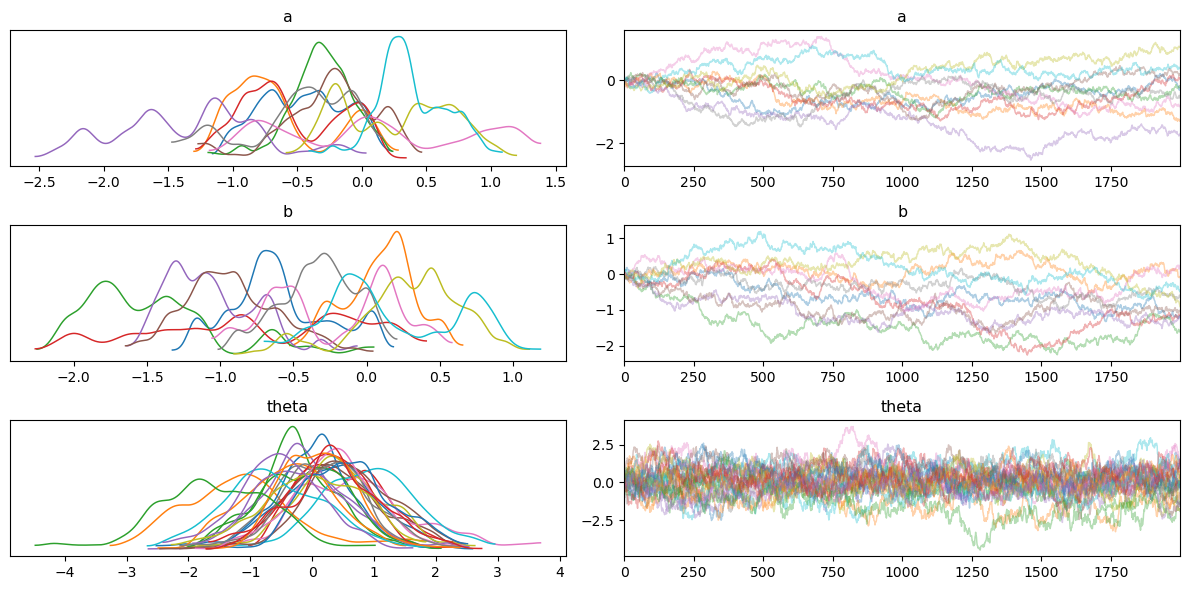

In [91]:
# --- Generate synthetic data ---
rng = np.random.default_rng(0)
P, I = 25, 10
true_a = rng.normal(0.5, 1.0, size=I)
true_b = rng.normal(0.0, 1.0, size=I)
true_theta = rng.normal(0.0, 1.0, size=P)

lin = np.outer(true_theta, true_a) + true_b[None, :]
prob = 1.0 / (1.0 + np.exp(-lin))
Y = (rng.uniform(size=(P, I)) < prob).astype(np.int32)


start_time = time()

# --- Run jitted MH sampler ---
traces, acc = mh_naive_jitted(
    Y,
    n_iter=2000,
    prop_sd_a_in=0.03,
    prop_sd_b_in=0.03,
    prop_sd_theta_in=0.18,
    seed=42
)

end_time = time()

print(f"MH sampler runtime: {end_time - start_time:.2f} seconds")

# --- Acceptance rates ---
print("Mean acceptance rates:")
print("a:", acc['a'].mean())
print("b:", acc['b'].mean())
print("theta:", acc['t'].mean())

# --- Posterior means after burn-in ---
burn = 500
a_hat = traces['a'][burn:].mean(axis=0)
b_hat = traces['b'][burn:].mean(axis=0)
theta_hat = traces['t'][burn:].mean(axis=0)

# First few true values
print("\nTrue values (first 5):")
print("true_a[:5]:", true_a[:5])
print("true_b[:5]:", true_b[:5])
print("true_theta[:5]:", true_theta[:5])

# First few posterior means
print("\nPosterior means (first 5):")
print("a_hat[:5]:", a_hat[:5])
print("b_hat[:5]:", b_hat[:5])
print("theta_hat[:5]:", theta_hat[:5])

# --- Compare to true values ---
a_diff = a_hat - true_a
b_diff = b_hat - true_b
theta_diff = theta_hat - true_theta

print("\nDifferences (posterior mean - true value) (first 5):")
print("a_diff[:5]:", a_diff[:5])
print("b_diff[:5]:", b_diff[:5])
print("theta_diff[:5]:", theta_diff[:5])

# --- Summary metrics ---
print("\nSummary of absolute differences:")
print("Mean absolute error a:", np.mean(np.abs(a_diff)))
print("Mean absolute error b:", np.mean(np.abs(b_diff)))
print("Mean absolute error theta:", np.mean(np.abs(theta_diff)))
print("Max absolute error a:", np.max(np.abs(a_diff)))
print("Max absolute error b:", np.max(np.abs(b_diff)))
print("Max absolute error theta:", np.max(np.abs(theta_diff)))

# --- ArviZ visualization ---
idata = az.from_dict(posterior={
    "a": traces['a'][None, :, :],  # single chain
    "b": traces['b'][None, :, :],
    "theta": traces['t'][None, :, :]
})

az.plot_trace(idata, var_names=["a", "b", "theta"])
plt.tight_layout()
plt.show()



### Parameter Blocked Metropolis-Gibbs

In [92]:
# -------------------------
# constants / prior scales
# -------------------------
variance = 100.0
sa = jnp.sqrt(variance)   # prior sd for a
sb = jnp.sqrt(variance)   # prior sd for b
stheta = 1.0              # prior sd for theta

# -------------------------
# stable log-prob functions
# -------------------------
LOG_2PI = jnp.log(2.0 * jnp.pi)

def normal_logpdf(x, sd):
    # elementwise log pdf of N(0, sd^2)
    return -0.5 * ((x / sd) ** 2) - 0.5 * LOG_2PI - jnp.log(sd)

def bernoulli_logpmf_from_logits(y, logits):
    # y in {0,1}, logits any real -> elementwise log prob
    # log P(Y=1) = -softplus(-logit) ; log P(Y=0) = -softplus(logit)
    # combine: y * (-softplus(-logit)) + (1-y) * (-softplus(logit))
    # numerically stable:
    log_prob1 = -jax.nn.softplus(-logits)   # log sigmoid(logits)
    log_prob0 = -jax.nn.softplus(logits)    # log (1 - sigmoid(logits))
    return y * log_prob1 + (1 - y) * log_prob0

# -------------------------
# module-level log_joint
# -------------------------
def log_joint(a, b, theta, Y):
    """
    a: (I,), b: (I,), theta: (P,), Y: (P, I) with entries 0/1
    returns scalar jnp log joint (prior + likelihood)
    """
    la = jnp.sum(normal_logpdf(a, sa))
    lb = jnp.sum(normal_logpdf(b, sb))
    lt = jnp.sum(normal_logpdf(theta, stheta))
    logits = jnp.outer(theta, a) + b[None, :]   # shape (P, I)
    lY = jnp.sum(bernoulli_logpmf_from_logits(Y, logits))
    return la + lb + lt + lY

# -------------------------
# JIT-able block Metropolis-Gibbs
# -------------------------
def mh_block_metropolis_gibbs_jit(Y,
                                  n_iter,
                                  prop_sd_a=0.5,
                                  prop_sd_b=0.5,
                                  prop_sd_theta=0.2,
                                  a_init=None,
                                  b_init=None,
                                  theta_init=None,
                                  seed=0):
    """
    JIT-friendly block Metropolis-within-Gibbs sampler.
    Returns traces (jnp arrays) and acc_rates (jnp scalars).
    NOTE: n_iter should be static when jitted (we'll jax.jit with static_argnums=(1,))
    """

    Y = jnp.asarray(Y)
    P, I = Y.shape

    a0 = jnp.zeros(I) if a_init is None else jnp.asarray(a_init)
    b0 = jnp.zeros(I) if b_init is None else jnp.asarray(b_init)
    theta0 = jnp.zeros(P) if theta_init is None else jnp.asarray(theta_init)

    curr_lp0 = log_joint(a0, b0, theta0, Y)

    # Pre-sample normals (one row per iteration) and uniforms for acceptance
    key = jax.random.PRNGKey(seed)
    key, k1, k2, k3, k4 = jax.random.split(key, 5)
    normals_a = jax.random.normal(k1, shape=(n_iter, I))
    normals_b = jax.random.normal(k2, shape=(n_iter, I))
    normals_theta = jax.random.normal(k3, shape=(n_iter, P))
    us = jax.random.uniform(k4, shape=(n_iter, 3))  # one uniform per block proposal

    # initial carry: (a, b, theta, curr_lp, acc_a, acc_b, acc_theta)
    carry0 = (a0, b0, theta0, curr_lp0,
              jnp.int32(0), jnp.int32(0), jnp.int32(0))

    def step(carry, inputs):
        a, b, theta, curr_lp, acc_a, acc_b, acc_theta = carry
        norm_a_row, norm_b_row, norm_theta_row, u_row = inputs

        # propose block a
        a_prop = a + prop_sd_a * norm_a_row
        lp_prop_a = log_joint(a_prop, b, theta, Y)
        accept_a = (jnp.log(u_row[0]) < (lp_prop_a - curr_lp))
        a = jnp.where(accept_a, a_prop, a)
        curr_lp = jnp.where(accept_a, lp_prop_a, curr_lp)
        acc_a = acc_a + accept_a.astype(jnp.int32)

        # propose block b (use updated a)
        b_prop = b + prop_sd_b * norm_b_row
        lp_prop_b = log_joint(a, b_prop, theta, Y)
        accept_b = (jnp.log(u_row[1]) < (lp_prop_b - curr_lp))
        b = jnp.where(accept_b, b_prop, b)
        curr_lp = jnp.where(accept_b, lp_prop_b, curr_lp)
        acc_b = acc_b + accept_b.astype(jnp.int32)

        # propose block theta (use updated a, b)
        theta_prop = theta + prop_sd_theta * norm_theta_row
        lp_prop_t = log_joint(a, b, theta_prop, Y)
        accept_t = (jnp.log(u_row[2]) < (lp_prop_t - curr_lp))
        theta = jnp.where(accept_t, theta_prop, theta)
        curr_lp = jnp.where(accept_t, lp_prop_t, curr_lp)
        acc_theta = acc_theta + accept_t.astype(jnp.int32)

        new_carry = (a, b, theta, curr_lp, acc_a, acc_b, acc_theta)
        snapshot = (a, b, theta)
        return new_carry, snapshot

    inputs_for_scan = (normals_a, normals_b, normals_theta, us)
    carry_final, snapshots = lax.scan(step, carry0, inputs_for_scan)

    a_stack, b_stack, theta_stack = snapshots   # shapes (n_iter, I), (n_iter, I), (n_iter, P)
    _, _, _, _, acc_a_final, acc_b_final, acc_theta_final = carry_final

    traces = {'a': a_stack, 'b': b_stack, 'theta': theta_stack}
    acc_rates = {
        'a': acc_a_final.astype(jnp.float32) / n_iter,
        'b': acc_b_final.astype(jnp.float32) / n_iter,
        'theta': acc_theta_final.astype(jnp.float32) / n_iter
    }
    return traces, acc_rates

# JIT-compile with n_iter static (index 1)
mh_block_metropolis_gibbs_jitted = jax.jit(mh_block_metropolis_gibbs_jit, static_argnums=(1,))


# -------------------------
# quick demo with synthetic data
# -------------------------
if __name__ == "__main__":
    # generate synthetic data (numpy)
    rng = np.random.default_rng(0)
    P, I = 25, 10
    true_a = rng.normal(0.5, 1.0, size=I)
    true_b = rng.normal(0.0, 1.0, size=I)
    true_theta = rng.normal(0.0, 1.0, size=P)

    lin = np.outer(true_theta, true_a) + true_b[None, :]
    prob = 1.0 / (1.0 + np.exp(-lin))
    Y = (rng.uniform(size=(P, I)) < prob).astype(np.int32)

    print("Starting JITed block Metropolis-Gibbs (first call will compile)...")
    t0 = time()
    traces, acc = mh_block_metropolis_gibbs_jitted(
        Y,
        n_iter=2000,
        prop_sd_a=0.03,
        prop_sd_b=0.03,
        prop_sd_theta=0.18,
        seed=42
    )
    t1 = time()
    print(f"Runtime (including compile): {t1 - t0:.2f} s")

    # convert traces to numpy for analysis / printing
    a_trace = np.array(traces['a'])
    b_trace = np.array(traces['b'])
    theta_trace = np.array(traces['theta'])
    acc_rates = {k: float(v) for k, v in acc.items()}

    print("Acceptance rates (per-block):", acc_rates)

    burn = 500
    a_hat = a_trace[burn:].mean(axis=0)
    b_hat = b_trace[burn:].mean(axis=0)
    theta_hat = theta_trace[burn:].mean(axis=0)

    print("\nTrue a (first 5):     ", np.round(true_a[:5], 3))
    print("Posterior mean a[:5]: ", np.round(a_hat[:5], 3))
    print("\nTrue b (first 5):     ", np.round(true_b[:5], 3))
    print("Posterior mean b[:5]: ", np.round(b_hat[:5], 3))
    print("\nTrue theta (first 5): ", np.round(true_theta[:5], 3))
    print("Posterior mean theta[:5]:", np.round(theta_hat[:5], 3))

    # simple summary errors
    print("\nMean absolute error a:", np.mean(np.abs(a_hat - true_a)))
    print("Mean absolute error b:", np.mean(np.abs(b_hat - true_b)))
    print("Mean absolute error theta:", np.mean(np.abs(theta_hat - true_theta)))


Starting JITed block Metropolis-Gibbs (first call will compile)...
Runtime (including compile): 0.29 s
Acceptance rates (per-block): {'a': 0.9325000643730164, 'b': 0.9005000591278076, 'theta': 0.5420000553131104}

True a (first 5):      [ 0.626  0.368  1.14   0.605 -0.036]
Posterior mean a[:5]:  [ 0.489 -0.085 -0.383  0.214 -1.868]

True b (first 5):      [-0.623  0.041 -2.325 -0.219 -1.246]
Posterior mean b[:5]:  [-0.74   0.151 -1.863 -0.22  -1.105]

True theta (first 5):  [-0.129  1.366 -0.665  0.352  0.903]
Posterior mean theta[:5]: [ 0.786 -0.742 -1.332 -0.368  0.054]

Mean absolute error a: 1.0410622945012542
Mean absolute error b: 0.3288042177894964
Mean absolute error theta: 0.7953974962480233


MH sampler runtime: 0.00 seconds
Mean acceptance rates:
a: 0.93250006
b: 0.90050006
theta: 0.54200006

True values (first 5):
true_a[:5]: [ 0.62573022  0.36789514  1.14042265  0.60490012 -0.03566937]
true_b[:5]: [-0.62327446  0.04132598 -2.32503077 -0.21879166 -1.24591095]
true_theta[:5]: [-0.12853466  1.36646347 -0.66519467  0.35151007  0.90347018]

Posterior means (first 5):
a_hat[:5]: [ 0.48927662 -0.08475902 -0.38337812  0.21446122 -1.8681778 ]
b_hat[:5]: [-0.74014455  0.1506963  -1.8630157  -0.2196798  -1.1046147 ]
theta_hat[:5]: [ 0.7861781  -0.7417108  -1.3319378  -0.36847413  0.0543586 ]

Differences (posterior mean - true value) (first 5):
a_diff[:5]: [-0.1364536  -0.45265415 -1.5238008  -0.3904389  -1.8325084 ]
b_diff[:5]: [-0.11687011  0.10937033  0.46201515 -0.00088814  0.14129627]
theta_diff[:5]: [ 0.9147128  -2.1081743  -0.6667431  -0.7199842  -0.84911156]

Summary of absolute differences:
Mean absolute error a: 1.0410626
Mean absolute error b: 0.32880408
Mean absolute er

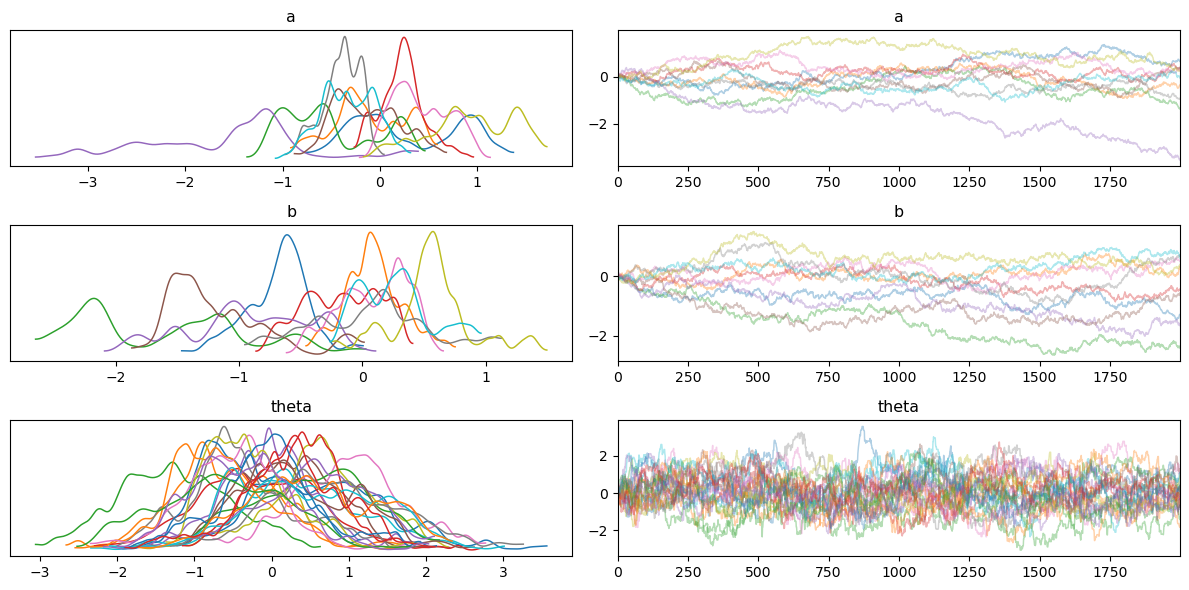

In [93]:
# --- Generate synthetic data ---
rng = np.random.default_rng(0)
P, I = 25, 10
true_a = rng.normal(0.5, 1.0, size=I)
true_b = rng.normal(0.0, 1.0, size=I)
true_theta = rng.normal(0.0, 1.0, size=P)

lin = np.outer(true_theta, true_a) + true_b[None, :]
prob = 1.0 / (1.0 + np.exp(-lin))
Y = (rng.uniform(size=(P, I)) < prob).astype(np.int32)


start_time = time()

# --- Run jitted MH sampler ---
traces, acc = mh_block_metropolis_gibbs_jitted(
    Y,
    n_iter=2000,
    prop_sd_a=0.03,
    prop_sd_b=0.03,
    prop_sd_theta=0.18,
    seed=42
)

end_time = time()

print(f"MH sampler runtime: {end_time - start_time:.2f} seconds")

# --- Acceptance rates ---
print("Mean acceptance rates:")
print("a:", acc['a'].mean())
print("b:", acc['b'].mean())
print("theta:", acc['theta'].mean())

# --- Posterior means after burn-in ---
burn = 500
a_hat = traces['a'][burn:].mean(axis=0)
b_hat = traces['b'][burn:].mean(axis=0)
theta_hat = traces['theta'][burn:].mean(axis=0)

# First few true values
print("\nTrue values (first 5):")
print("true_a[:5]:", true_a[:5])
print("true_b[:5]:", true_b[:5])
print("true_theta[:5]:", true_theta[:5])

# First few posterior means
print("\nPosterior means (first 5):")
print("a_hat[:5]:", a_hat[:5])
print("b_hat[:5]:", b_hat[:5])
print("theta_hat[:5]:", theta_hat[:5])

# --- Compare to true values ---
a_diff = a_hat - true_a
b_diff = b_hat - true_b
theta_diff = theta_hat - true_theta

print("\nDifferences (posterior mean - true value) (first 5):")
print("a_diff[:5]:", a_diff[:5])
print("b_diff[:5]:", b_diff[:5])
print("theta_diff[:5]:", theta_diff[:5])

# --- Summary metrics ---
print("\nSummary of absolute differences:")
print("Mean absolute error a:", np.mean(np.abs(a_diff)))
print("Mean absolute error b:", np.mean(np.abs(b_diff)))
print("Mean absolute error theta:", np.mean(np.abs(theta_diff)))
print("Max absolute error a:", np.max(np.abs(a_diff)))
print("Max absolute error b:", np.max(np.abs(b_diff)))
print("Max absolute error theta:", np.max(np.abs(theta_diff)))

# --- ArviZ visualization ---
idata = az.from_dict(posterior={
    "a": traces['a'][None, :, :],  # single chain
    "b": traces['b'][None, :, :],
    "theta": traces['theta'][None, :, :]
})

az.plot_trace(idata, var_names=["a", "b", "theta"])
plt.tight_layout()
plt.show()

With this, the potential speedup of using coupling becomes clear!

## PolyaGamma augmentation

A PolyaGamma data augmentation allows us to directly solve this using Gibbs sampling:

$$\pi(w, \Psi|y) \propto p(a, b, \theta) \prod_{p, i} \exp[(y_{p, i} - \frac{1}{2})(a_i\theta_p + b_i) - \frac{w_{p, i}}{2}(a_i\theta_p + b_i)^2]g_0(w_{p, i})$$

where $g_0(w) = \sum_{k = 0}^\infty (-1)^k \frac{(2k + 1)}{\sqrt{2\pi w^3}}\exp(- \frac{(k + 1)^2}{8w}) \mathbb{1}_{(0, \infty)}(w)$.

This leads to conditionals:

$$W_{p, i}| a_i, \theta_p, b_i, y_{p, i} \sim PolyaGamma(1, a_i\theta_p + b_i)$$

$$a_i|w_{\cdot, i}, \theta_p, b_i, y_{p, i} \sim N(m_i, u_i^2)$$

$$b_i|w_{\cdot, i}, \theta_p, a_i, y_{p, i} \sim N(n_i, v_i^2)$$

$$\theta_p|w_{p, \cdot}, a_i, b_i, y_{p, i} \sim N(o_p, x_p^2)$$

where 

$$u_i = (\frac{1}{\sigma_a^2} + \sum_{p \in [P]} w_{p, i}\theta_p^2)^{-1}$$

$$m_i = u_i^2\sum_{p \in [P]}\theta_p(y_{p, i} - 0.5 - b_iw_{p, i})$$

$$v_i = (\frac{1}{\sigma_b^2} + \sum_{p \in [P]} w_{p, i})^{-1}$$

$$n_i = v_i^2\sum_{p \in [P]} (y_{p, i} - 0.5 - a_i\theta_pw_{p, i})$$

$$x_p^2 = (1 + \sum_{i \in [I]}w_{p, i}a_i^2)^{-1}$$

$$o_p = x_p^2 \sum_{i \in [I]} a_i(y_{p, i} - 0.5 - b_iw_{p, i})$$

Additionally since $a_i$ and $b_i$ are strongly correlated, we update them jointly.

Let $U \in \mathbb{R}^{2I}$ and $V \in \mathbb{R}^{2I \times 2I}$ where

$$U_i = \sum_{p \in [P]}(y_{p, i} - 0.5)\theta_p$$

$$U_{i + p} = \sum_{p \in [P]}(y_{p, i} - 0.5)$$

$$D_{i, j} = \begin{cases} \frac{1}{\sigma_a^2} + \sum_{p \in [P]} W_{p, i} \theta_p^2 &, \text{ if } i = j \text{ and } i \leq I\\ \frac{1}{\sigma_b^2} + \sum_{p \in [P]} W_{p, i} &, \text{ if } i = j \text{ and } I + 1 \leq i \leq 2I\\ \sum_{p \in [P]} \theta_pW_{p, i} &, \text{ if } |j - i| = p\\ 0 &, \text{ otherwise} \end{cases}$$

$$\begin{pmatrix} a\\b \end{pmatrix}|w, \theta, y \sim N(D^{-1}U, D^{-1})$$

Iteration 1/20000 complete
Iteration 1000/20000 complete
Iteration 2000/20000 complete
Iteration 3000/20000 complete
Iteration 4000/20000 complete
Iteration 5000/20000 complete
Iteration 6000/20000 complete
Iteration 7000/20000 complete
Iteration 8000/20000 complete
Iteration 9000/20000 complete
Iteration 10000/20000 complete
Iteration 11000/20000 complete
Iteration 12000/20000 complete
Iteration 13000/20000 complete
Iteration 14000/20000 complete
Iteration 15000/20000 complete
Iteration 16000/20000 complete
Iteration 17000/20000 complete
Iteration 18000/20000 complete
Iteration 19000/20000 complete
Iteration 20000/20000 complete

a posterior recovery (95% credible intervals):
Index     True  Posterior mean     CI lower     CI upper
    0    1.196           1.740        1.483        2.012
    1    0.786           1.212        1.009        1.431
    2    0.727           1.044        0.850        1.245
    3    1.051           1.511        1.282        1.758
    4    1.219           1.52

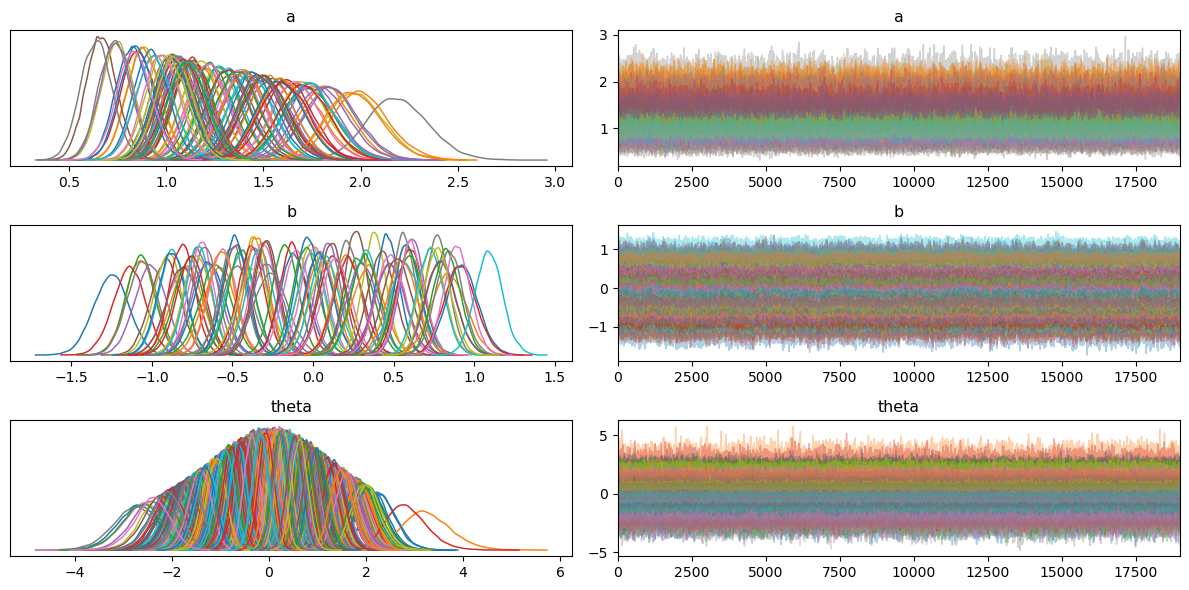

In [94]:
# ------------------------------
# 1) Simulate "true" IRT data
# ------------------------------
P, I = 1000, 100
np.random.seed(123)

true_a = np.random.uniform(0.5, 1.5, size=I)
true_b = np.linspace(-1, 1, I)
true_theta = np.random.normal(0, 1.25, size=P)

# Generate binary responses
Y = np.zeros((P, I), dtype=int)
for p in range(P):
    for i in range(I):
        p_ = 1 / (1 + np.exp(-(true_a[i]*true_theta[p] + true_b[i])))
        Y[p, i] = np.random.binomial(1, p_)

# ------------------------------
# 2) DA-IRT sampler
# ------------------------------
def DA_IRT_python(Y, n_iter=1000, blocking=True, mu_a=1.2, sigma_a2=100.0, sigma_b2=100.0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    P, I = Y.shape
    a = np.ones(I)
    b = np.zeros(I)
    theta = 0.1 * np.ones(P)
    W = np.zeros((P, I))
    res_a = np.zeros((n_iter, I))
    res_b = np.zeros((n_iter, I))
    res_theta = np.zeros((n_iter, P))
    
    for k in range(n_iter):
        # Sample W
        for i in range(I):
            z = a[i]*theta + b[i]
            W[:, i] = random_polyagamma(z=z, size=P, method="devroye")
        
        # Sample theta
        for p in range(P):
            vsq = 1 / (1 + np.sum(W[p, :] * a**2))
            m = vsq * np.sum(a * (Y[p, :] - 0.5) - W[p, :] * a * b)
            theta[p] = m + np.sqrt(vsq) * np.random.randn()
        
        # Sample (a, b)
        if blocking:
            U1 = theta @ (Y - 0.5)
            U2 = np.sum(Y - 0.5, axis=0)
            cp1 = np.sum(W, axis=0)
            cp2 = theta @ W
            cp3 = theta**2 @ W
            for i in range(I):
                D = np.array([[1/sigma_a2 + cp3[i], cp2[i]],
                              [cp2[i], 1/sigma_b2 + cp1[i]]])
                U = np.array([U1[i], U2[i]])
                L = np.linalg.cholesky(D)
                mean = np.linalg.solve(D, U)
                z = np.random.randn(2)
                ab_sample = mean + np.linalg.solve(L.T, z)
                a[i], b[i] = ab_sample[0], ab_sample[1]
        else:
            for i in range(I):
                vsq = 1 / (1/sigma_a2 + np.sum(W[:, i] * theta**2))
                m = vsq * np.sum(theta * (Y[:, i] - 0.5 - b[i]*W[:, i]))
                a[i] = m + np.sqrt(vsq)*np.random.randn()
                vsq = 1 / (1/sigma_b2 + np.sum(W[:, i]))
                m = vsq * np.sum(Y[:, i] - 0.5 - a[i]*W[:, i]*theta)
                b[i] = m + np.sqrt(vsq)*np.random.randn()
        
        if (k+1) % 1000 == 0 or k == 0:
            print(f"Iteration {k+1}/{n_iter} complete")
        
        res_a[k, :] = a
        res_b[k, :] = b
        res_theta[k, :] = theta
    
    return {"a": res_a, "b": res_b, "theta": res_theta}

# ------------------------------
# 3) Run sampler
# ------------------------------
traces = DA_IRT_python(Y, n_iter=20000, blocking=True, seed=123)

burn_in = 1000
a_post = traces["a"][burn_in:, :]
b_post = traces["b"][burn_in:, :]
theta_post = traces["theta"][burn_in:, :]

# ------------------------------
# 4) Compute posterior means
# ------------------------------
a_hat = a_post.mean(axis=0)
b_hat = b_post.mean(axis=0)
theta_hat = theta_post.mean(axis=0)

# ------------------------------
# 5) Compute 95% credible intervals (NumPy)
# ------------------------------
def credible_interval(samples, prob=0.95):
    lower = np.percentile(samples, 100*(1-prob)/2, axis=0)
    upper = np.percentile(samples, 100*(1+prob)/2, axis=0)
    return lower, upper

a_lower, a_upper = credible_interval(a_post)
b_lower, b_upper = credible_interval(b_post)
theta_lower, theta_upper = credible_interval(theta_post)

# ------------------------------
# 6) Print first and last 5 parameters
# ------------------------------
def print_ci(name, true_val, est_val, lower, upper, first_last=5):
    print(f"\n{name} posterior recovery (95% credible intervals):")
    idxs = list(range(first_last)) + list(range(-first_last, 0))
    print(f"{'Index':>5} {'True':>8} {'Posterior mean':>15} {'CI lower':>12} {'CI upper':>12}")
    for i in idxs:
        print(f"{i:5d} {true_val[i]:8.3f} {est_val[i]:15.3f} {lower[i]:12.3f} {upper[i]:12.3f}")

print_ci("a", true_a, a_hat, a_lower, a_upper)
print_ci("b", true_b, b_hat, b_lower, b_upper)
print_ci("theta", true_theta, theta_hat, theta_lower, theta_upper)

# ------------------------------
# 7) Optional: visualize chains with ArviZ
# ------------------------------
idata = az.from_dict(posterior={
    "a": a_post[None, :, :],
    "b": b_post[None, :, :],
    "theta": theta_post[None, :, :]
})
az.plot_trace(idata, var_names=["a", "b", "theta"])
plt.tight_layout()
plt.show()


# Coupling

## Maximal Coupling

Sample a couple $p$ and $q$ with parameter $\eta \in (0, 1]$. The coupling maximizes $P(X = Y)$ when $\eta = 1$, but the variance of the cost is bounded when $\eta < 1$.

1. Sample $X \sim p$
2. Sample $W \sim Unif(0, 1)$

    (a) If $W \leq \min(\eta, \frac{q(X)}{p(X)})$. Set $Y = X$

    (b) Otherwise sample $Y^* \sim q$ and $W^* \sim Unif(0, 1)$ until $W^* > \eta\frac{p(Y^*)}{q(Y^*)}$, and set $Y = Y^*$
4. Return $(X, Y)$.


### Standard Pythonic Loops

#### Fully Metropolis-Gibbs

In [101]:
variance = 100

sa = jnp.sqrt(variance)
sb = jnp.sqrt(variance)

def log_joint(a, b, t, Y):
    la = jnp.sum(dist.Normal(0, sa).log_prob(a))
    lb = jnp.sum(dist.Normal(0, sb).log_prob(b))
    lt = jnp.sum(dist.Normal(0, 1).log_prob(t))

    pi_val = jnp.outer(t, a) + b[None, :]
    
    lY = jnp.sum(dist.Bernoulli(logits=pi_val).log_prob(Y))

    return la + lb + lt + lY


def maximal_coupling_proposal(key, mu1, mu2, sigma1, sigma2, eta = 1.0):
    lograt = lambda x: dist.Normal(mu1, sigma1).log_prob(x) - dist.Normal(mu2, sigma2).log_prob(x)
    
    key, subkey = jax.random.split(key)
    prop1 = mu1 + sigma1 * jax.random.normal(subkey)

    key, subkey = jax.random.split(key)
    lu = jnp.log(jax.random.uniform(subkey))

    if lu <= jnp.minimum(jnp.log(eta), -lograt(prop1)):
        prop2 = prop1

    else:
        key, subkey = jax.random.split(key)
        prop2 = mu2 + sigma2 * jax.random.normal(subkey)

        key, subkey = jax.random.split(key)
        lu = jnp.log(jax.random.uniform(subkey))  

        while (lu <= (jnp.log(eta) + lograt(prop2))):
            key, subkey = jax.random.split(key)
            prop2 = mu2 + sigma2 * jax.random.normal(subkey)

            key, subkey = jax.random.split(key)
            lu = jnp.log(jax.random.uniform(subkey))  

    return key, prop1, prop2

def mh_step_max_couple(key, x1, x2, joint1, joint2, prop_sd, clp1, clp2, acc1, acc2, i, eta = 1.0):
    key, prop1, prop2 = maximal_coupling_proposal(key, x1[i], x2[i], prop_sd, prop_sd, eta = eta)

    x_prop1 = x1.at[i].set(prop1)
    x_prop2 = x2.at[i].set(prop2)

    lp_prop1 = float(joint1(x_prop1))
    lp_prop2 = float(joint2(x_prop2))

    log_alpha1 = lp_prop1 - clp1
    log_alpha2 = lp_prop2 - clp2

    key, subkey = jax.random.split(key)

    log_u = jnp.log(jax.random.uniform(subkey))

    if log_u < log_alpha1:
        x1 = x_prop1
        clp1 = lp_prop1
        acc1[i] += 1

    if log_u < log_alpha2:
        x2 = x_prop2
        clp2 = lp_prop2
        acc2[i] += 1

    return key, x1, x2, clp1, clp2, acc1, acc2

def mh_max_couple(Y, n_iter = 2000, prop_sd_a = 0.5, prop_sd_b = 0.5, prop_sd_t = 0.2, a_init = None, b_init = None, t_init = None):

    Y1 = jnp.asarray(Y[0])
    Y2 = jnp.asarray(Y[1])
    
    P, I = Y1.shape

    if a_init is None:
        a1 = jnp.zeros(I)
        a2 = jnp.zeros(I)
        
    else:
        a1 = jnp.asarray(a_init[0])
        a2 = jnp.asarray(a_init[1])
        
    if b_init is None:
        b1 = jnp.zeros(I)
        b2 = jnp.zeros(I)
        
    else:
        b1 = jnp.asarray(b_init[0])
        b2 = jnp.asarray(b_init[1])
        
    if t_init is None:
        t1 = jnp.zeros(P)
        t2 = jnp.zeros(P)
        
    else:
        t1 = jnp.asarray(t_init[0])
        t2 = jnp.asarray(t_init[1])

    trace_a = np.zeros((2, n_iter, I), dtype=float)
    trace_b = np.zeros((2, n_iter, I), dtype=float)
    trace_t = np.zeros((2, n_iter, P), dtype=float)

    acc_a1 = np.zeros(I, dtype=int)
    acc_b1 = np.zeros(I, dtype=int)
    acc_t1 = np.zeros(P, dtype=int)

    acc_a2 = np.zeros(I, dtype=int)
    acc_b2 = np.zeros(I, dtype=int)
    acc_t2 = np.zeros(P, dtype=int)

    key = jax.random.PRNGKey(0)

    curr_lp1 = float(log_joint(a1, b1, t1, Y1))
    curr_lp2 = float(log_joint(a2, b2, t2, Y2))

    for it in range(n_iter):
        for i in range(I):
            joint1 = lambda x: log_joint(x, b1, t1, Y1)
            joint2 = lambda x: log_joint(x, b2, t2, Y2)

            key, a1, a2, curr_lp1, curr_lp2, acc_a1, acc_a2 = mh_step_max_couple(key, a1, a2, joint1, joint2, prop_sd_a, curr_lp1, curr_lp2, acc_a1, acc_a2, i)

        for i in range(I):
            joint1 = lambda x: log_joint(a1, x, t1, Y1)
            joint2 = lambda x: log_joint(a2, x, t2, Y2)

            key, b1, b2, curr_lp1, curr_lp2, acc_b1, acc_b2 = mh_step_max_couple(key, b1, b2, joint1, joint2, prop_sd_b, curr_lp1, curr_lp2, acc_b1, acc_b2, i)

        for p in range(P):
            joint1 = lambda x: log_joint(a1, b1, x, Y1)
            joint2 = lambda x: log_joint(a2, b2, x, Y2)

            key, t1, t2, curr_lp1, curr_lp2, acc_t1, acc_t2 = mh_step_max_couple(key, t1, t2, joint1, joint2, prop_sd_t, curr_lp1, curr_lp2, acc_t1, acc_t2, p)

        trace_a[0, it, :] = np.array(a1)
        trace_a[1, it, :] = np.array(a2)
        trace_b[0, it, :] = np.array(b1)
        trace_b[1, it, :] = np.array(b2)
        trace_t[0, it, :] = np.array(t1)
        trace_t[1, it, :] = np.array(t2)

    traces = {'a': trace_a, 'b': trace_b, 't': trace_t}

    acc_rates = {
        'a': (acc_a1 / float(n_iter), acc_a2 / float(n_iter)),
        'b': (acc_b1 / float(n_iter), acc_b2 / float(n_iter)),
        't': (acc_t1 / float(n_iter), acc_t2 / float(n_iter)),
    }
    
    return traces, acc_rates
    

Coupled MH sampler runtime: 198.88 seconds

Mean acceptance rates (chain 0):
 mean acc a: 0.9803499999999999
 mean acc b: 0.9732
 mean acc t: 0.9245200000000001

Mean acceptance rates (chain 1):
 mean acc a: 0.98325
 mean acc b: 0.9759499999999999
 mean acc t: 0.84598

Posterior means (first 5):
a_hat[:5]: [-0.61661248 -0.34490776 -0.59309095 -0.74016103 -0.62690468]
b_hat[:5]: [-0.49427869  0.15640814 -1.0742387  -0.73907563 -0.81571343]
theta_hat[:5]: [-0.00926989 -0.51250715  0.03050184  0.31783578 -0.04435889]

Differences (posterior mean - true value) first 5:
a_diff[:5]: [-1.2423427  -0.7128029  -1.7335136  -1.34506115 -0.59123531]
b_diff[:5]: [ 0.12899577  0.11508216  1.25079207 -0.52028397  0.43019751]
theta_diff[:5]: [ 0.11926477 -1.87897063  0.69569652 -0.03367429 -0.94782907]

Summary of absolute differences:
Mean abs error a: 1.1144890732241524
Mean abs error b: 0.5267659303626913
Mean abs error theta: 0.8695262941648093
Max abs error a: 1.9551467598545047
Max abs error b: 

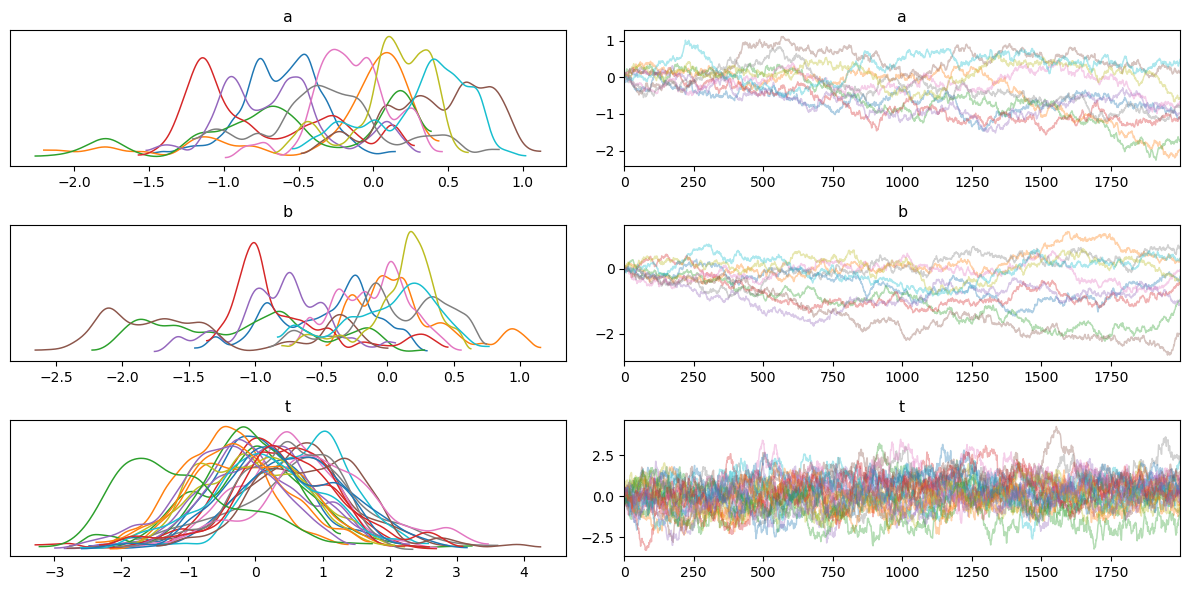

In [102]:
rng = np.random.default_rng(0)
P, I = 25, 10

# true parameters
true_a = rng.normal(0.5, 1.0, size=I)
true_b = rng.normal(0.0, 1.0, size=I)
true_theta = rng.normal(0.0, 1.0, size=P)

lin = np.outer(true_theta, true_a) + true_b[None, :]
prob = 1.0 / (1.0 + np.exp(-lin))
Y = (rng.uniform(size=(P, I)) < prob).astype(np.int32)

# create two different initializations for the two chains
# (same data Y for both chains; different starts)
a_init = (jnp.zeros(I), jnp.ones(I) * 2.0)   # chain0 zeros, chain1 2.0
b_init = (jnp.zeros(I), jnp.ones(I) * -2.0)
t_init = (jnp.zeros(P), jnp.ones(P) * 1.5)

# run the coupled sampler
n_iter = 2000
prop_sd_a = 0.03
prop_sd_b = 0.03
prop_sd_t = 0.18
eta = 1.0  # set <1.0 to bound cost if desired

start_time = time()
traces, acc = mh_max_couple(
    (Y, Y),
    n_iter=n_iter,
    prop_sd_a=prop_sd_a,
    prop_sd_b=prop_sd_b,
    prop_sd_t=prop_sd_t,
    a_init=a_init,
    b_init=b_init,
    t_init=t_init,
)
end_time = time()

print(f"Coupled MH sampler runtime: {end_time - start_time:.2f} seconds\n")

# acc is dict of tuples (chain0, chain1) each an array per-coordinate
print("Mean acceptance rates (chain 0):")
print(" mean acc a:", np.mean(acc['a'][0]))
print(" mean acc b:", np.mean(acc['b'][0]))
print(" mean acc t:", np.mean(acc['t'][0]))
print("\nMean acceptance rates (chain 1):")
print(" mean acc a:", np.mean(acc['a'][1]))
print(" mean acc b:", np.mean(acc['b'][1]))
print(" mean acc t:", np.mean(acc['t'][1]))

# Posterior means after burn-in (use chain 0 by default)
chain_idx = 0
a_tr = traces['a'][chain_idx]  # shape (n_iter, I)
b_tr = traces['b'][chain_idx]
t_tr = traces['t'][chain_idx]

a_hat = a_tr.mean(axis=0)
b_hat = b_tr.mean(axis=0)
theta_hat = t_tr.mean(axis=0)

print("\nPosterior means (first 5):")
print("a_hat[:5]:", a_hat[:5])
print("b_hat[:5]:", b_hat[:5])
print("theta_hat[:5]:", theta_hat[:5])

# Compare to truth
a_diff = a_hat - true_a
b_diff = b_hat - true_b
theta_diff = theta_hat - true_theta

print("\nDifferences (posterior mean - true value) first 5:")
print("a_diff[:5]:", a_diff[:5])
print("b_diff[:5]:", b_diff[:5])
print("theta_diff[:5]:", theta_diff[:5])

print("\nSummary of absolute differences:")
print("Mean abs error a:", np.mean(np.abs(a_diff)))
print("Mean abs error b:", np.mean(np.abs(b_diff)))
print("Mean abs error theta:", np.mean(np.abs(theta_diff)))
print("Max abs error a:", np.max(np.abs(a_diff)))
print("Max abs error b:", np.max(np.abs(b_diff)))
print("Max abs error theta:", np.max(np.abs(theta_diff)))

# --- Approximate meeting time (chains close enough) ---
tolerance = 1e-4  # adjust as needed
meeting_time = None

for it in range(n_iter):
    close_a = np.allclose(traces['a'][0, it, :], traces['a'][1, it, :], atol=tolerance)
    close_b = np.allclose(traces['b'][0, it, :], traces['b'][1, it, :], atol=tolerance)
    close_t = np.allclose(traces['t'][0, it, :], traces['t'][1, it, :], atol=tolerance)
    
    if close_a and close_b and close_t:
        meeting_time = it
        break

if meeting_time is not None:
    print(f"\nChains approximately met at iteration (0-based): {meeting_time}")
else:
    print("\nChains did NOT meet within the run (parameters not within tolerance).")

# Optional: ArviZ diagnostics / traceplot for chain 0
try:
    idata = az.from_dict(
        posterior={
            "a": traces['a'][chain_idx][None, :, :],  # shape (chain=1, draws, I)
            "b": traces['b'][chain_idx][None, :, :],
            "t": traces['t'][chain_idx][None, :, :],
        }
    )
    az.plot_trace(idata, var_names=["a", "b", "t"])
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("ArviZ plotting failed:", e)


#### Parameter Blocked Metropolis-Gibbs

In [103]:
variance = 100

sa = jnp.sqrt(variance)
sb = jnp.sqrt(variance)

def log_joint(a, b, t, Y):
    la = jnp.sum(dist.Normal(0, sa).log_prob(a))
    lb = jnp.sum(dist.Normal(0, sb).log_prob(b))
    lt = jnp.sum(dist.Normal(0, 1).log_prob(t))

    pi_val = jnp.outer(t, a) + b[None, :]
    
    lY = jnp.sum(dist.Bernoulli(logits=pi_val).log_prob(Y))

    return la + lb + lt + lY


def block_maximal_coupling_proposal(key, mu1, mu2, sigma1, sigma2, eta = 1.0):
    lograt = lambda x: jnp.sum(dist.Normal(mu1, sigma1).log_prob(x) - dist.Normal(mu2, sigma2).log_prob(x))
    
    key, subkey = jax.random.split(key)
    prop1 = mu1 + sigma1 * jax.random.normal(subkey, shape = mu1.shape)

    key, subkey = jax.random.split(key)
    lu = jnp.log(jax.random.uniform(subkey))

    if lu <= jnp.minimum(jnp.log(eta), -lograt(prop1)):
        prop2 = prop1

    else:
        key, subkey = jax.random.split(key)
        prop2 = mu2 + sigma2 * jax.random.normal(subkey, shape = mu2.shape)

        key, subkey = jax.random.split(key)
        lu = jnp.log(jax.random.uniform(subkey))  

        while (lu <= (jnp.log(eta) + lograt(prop2))):
            key, subkey = jax.random.split(key)
            prop2 = mu2 + sigma2 * jax.random.normal(subkey)

            key, subkey = jax.random.split(key)
            lu = jnp.log(jax.random.uniform(subkey))  

    return key, prop1, prop2

def mh_block_step_max_couple(key, x1, x2, joint1, joint2, prop_sd, clp1, clp2, acc1, acc2, eta = 1.0):
    key, prop1, prop2 = block_maximal_coupling_proposal(key, x1, x2, prop_sd, prop_sd, eta = eta)

    x_prop1 = prop1
    x_prop2 = prop2

    lp_prop1 = float(joint1(x_prop1))
    lp_prop2 = float(joint2(x_prop2))

    log_alpha1 = lp_prop1 - clp1
    log_alpha2 = lp_prop2 - clp2

    key, subkey = jax.random.split(key)

    log_u = jnp.log(jax.random.uniform(subkey))

    if log_u < log_alpha1:
        x1 = x_prop1
        clp1 = lp_prop1
        acc1 += 1

    if log_u < log_alpha2:
        x2 = x_prop2
        clp2 = lp_prop2
        acc2 += 1

    return key, x1, x2, clp1, clp2, acc1, acc2

def mh_block_max_couple(Y, n_iter = 2000, prop_sd_a = 0.5, prop_sd_b = 0.5, prop_sd_t = 0.2, a_init = None, b_init = None, t_init = None):

    Y1 = jnp.asarray(Y[0])
    Y2 = jnp.asarray(Y[1])
    
    P, I = Y1.shape

    if a_init is None:
        a1 = jnp.zeros(I)
        a2 = jnp.zeros(I)
        
    else:
        a1 = jnp.asarray(a_init[0])
        a2 = jnp.asarray(a_init[1])
        
    if b_init is None:
        b1 = jnp.zeros(I)
        b2 = jnp.zeros(I)
        
    else:
        b1 = jnp.asarray(b_init[0])
        b2 = jnp.asarray(b_init[1])
        
    if t_init is None:
        t1 = jnp.zeros(P)
        t2 = jnp.zeros(P)
        
    else:
        t1 = jnp.asarray(t_init[0])
        t2 = jnp.asarray(t_init[1])

    trace_a = np.zeros((2, n_iter, I), dtype=float)
    trace_b = np.zeros((2, n_iter, I), dtype=float)
    trace_t = np.zeros((2, n_iter, P), dtype=float)

    acc_a1 = 0
    acc_b1 = 0
    acc_t1 = 0

    acc_a2 = 0
    acc_b2 = 0
    acc_t2 = 0

    key = jax.random.PRNGKey(0)

    curr_lp1 = float(log_joint(a1, b1, t1, Y1))
    curr_lp2 = float(log_joint(a2, b2, t2, Y2))

    for it in range(n_iter):
        joint1 = lambda x: log_joint(x, b1, t1, Y1)
        joint2 = lambda x: log_joint(x, b2, t2, Y2)

        key, a1, a2, curr_lp1, curr_lp2, acc_a1, acc_a2 = mh_block_step_max_couple(key, a1, a2, joint1, joint2, prop_sd_a, curr_lp1, curr_lp2, acc_a1, acc_a2)

        joint1 = lambda x: log_joint(a1, x, t1, Y1)
        joint2 = lambda x: log_joint(a2, x, t2, Y2)

        key, b1, b2, curr_lp1, curr_lp2, acc_b1, acc_b2 = mh_block_step_max_couple(key, b1, b2, joint1, joint2, prop_sd_b, curr_lp1, curr_lp2, acc_b1, acc_b2)

        joint1 = lambda x: log_joint(a1, b1, x, Y1)
        joint2 = lambda x: log_joint(a2, b2, x, Y2)

        key, t1, t2, curr_lp1, curr_lp2, acc_t1, acc_t2 = mh_block_step_max_couple(key, t1, t2, joint1, joint2, prop_sd_t, curr_lp1, curr_lp2, acc_t1, acc_t2)

        trace_a[0, it, :] = np.array(a1)
        trace_a[1, it, :] = np.array(a2)
        trace_b[0, it, :] = np.array(b1)
        trace_b[1, it, :] = np.array(b2)
        trace_t[0, it, :] = np.array(t1)
        trace_t[1, it, :] = np.array(t2)

    traces = {'a': trace_a, 'b': trace_b, 't': trace_t}

    acc_rates = {
        'a': (acc_a1 / float(n_iter), acc_a2 / float(n_iter)),
        'b': (acc_b1 / float(n_iter), acc_b2 / float(n_iter)),
        't': (acc_t1 / float(n_iter), acc_t2 / float(n_iter)),
    }
    
    return traces, acc_rates
    

Coupled MH sampler runtime: 11.58 seconds

Mean acceptance rates (chain 0):
 mean acc a: 0.9395
 mean acc b: 0.895
 mean acc t: 0.4785

Mean acceptance rates (chain 1):
 mean acc a: 0.9295
 mean acc b: 0.91
 mean acc t: 0.275

Posterior means (first 5):
a_hat[:5]: [-0.98953404 -1.05631656 -1.08721898  0.05035858 -0.00804309]
b_hat[:5]: [-1.4694791  -0.10935357 -1.2115817  -0.77216139 -0.54196417]
theta_hat[:5]: [ 0.46967131 -0.44468147  0.67642143 -0.10278543  0.28887353]

Differences (posterior mean - true value) first 5:
a_diff[:5]: [-1.61526426 -1.4242117  -2.22764163 -0.55454154  0.02762628]
b_diff[:5]: [-0.84620464 -0.15067955  1.11344907 -0.55336972  0.70394678]
theta_diff[:5]: [ 0.59820597 -1.81114494  1.34161611 -0.4542955  -0.61459665]

Summary of absolute differences:
Mean abs error a: 1.5659727374035803
Mean abs error b: 0.6647367370471988
Mean abs error theta: 1.0067875835194533
Max abs error a: 3.136156249025246
Max abs error b: 1.1134490733303455
Max abs error theta: 2.34

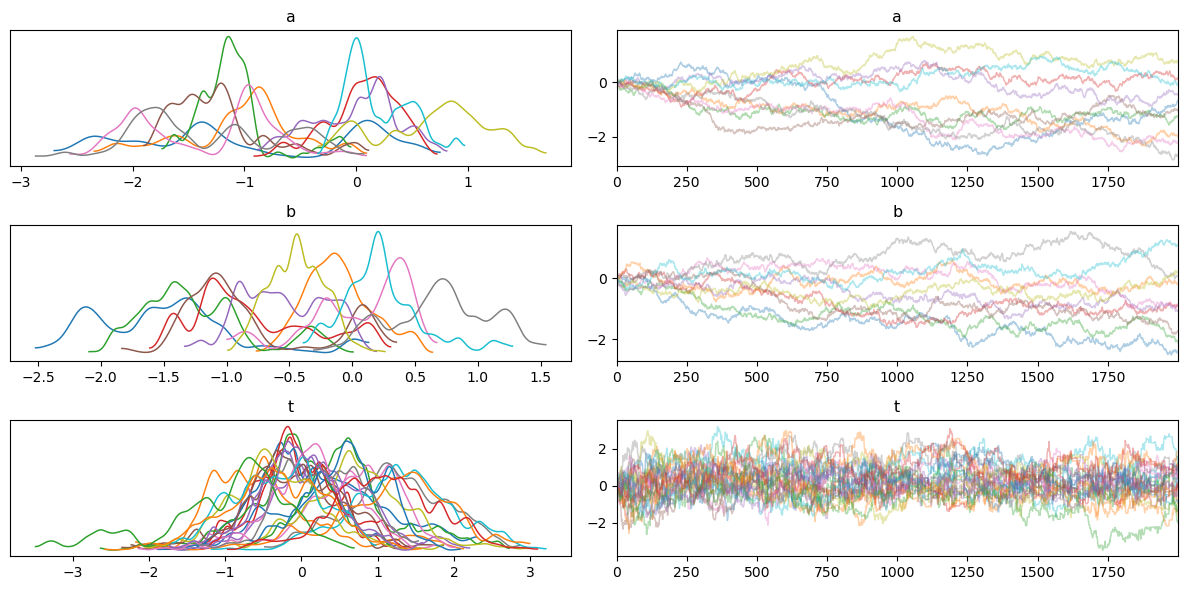

In [104]:
rng = np.random.default_rng(0)
P, I = 25, 10

# true parameters
true_a = rng.normal(0.5, 1.0, size=I)
true_b = rng.normal(0.0, 1.0, size=I)
true_theta = rng.normal(0.0, 1.0, size=P)

lin = np.outer(true_theta, true_a) + true_b[None, :]
prob = 1.0 / (1.0 + np.exp(-lin))
Y = (rng.uniform(size=(P, I)) < prob).astype(np.int32)

# create two different initializations for the two chains
# (same data Y for both chains; different starts)
a_init = (jnp.zeros(I), jnp.ones(I) * 2.0)   # chain0 zeros, chain1 2.0
b_init = (jnp.zeros(I), jnp.ones(I) * -2.0)
t_init = (jnp.zeros(P), jnp.ones(P) * 1.5)

# run the coupled sampler
n_iter = 2000
prop_sd_a = 0.03
prop_sd_b = 0.03
prop_sd_t = 0.18
eta = 1.0  # set <1.0 to bound cost if desired

start_time = time()
traces, acc = mh_block_max_couple(
    (Y, Y),
    n_iter=n_iter,
    prop_sd_a=prop_sd_a,
    prop_sd_b=prop_sd_b,
    prop_sd_t=prop_sd_t,
    a_init=a_init,
    b_init=b_init,
    t_init=t_init,
)
end_time = time()

print(f"Coupled MH sampler runtime: {end_time - start_time:.2f} seconds\n")

# acc is dict of tuples (chain0, chain1) each an array per-coordinate
print("Mean acceptance rates (chain 0):")
print(" mean acc a:", np.mean(acc['a'][0]))
print(" mean acc b:", np.mean(acc['b'][0]))
print(" mean acc t:", np.mean(acc['t'][0]))
print("\nMean acceptance rates (chain 1):")
print(" mean acc a:", np.mean(acc['a'][1]))
print(" mean acc b:", np.mean(acc['b'][1]))
print(" mean acc t:", np.mean(acc['t'][1]))

# Posterior means after burn-in (use chain 0 by default)
chain_idx = 0
a_tr = traces['a'][chain_idx]  # shape (n_iter, I)
b_tr = traces['b'][chain_idx]
t_tr = traces['t'][chain_idx]

a_hat = a_tr.mean(axis=0)
b_hat = b_tr.mean(axis=0)
theta_hat = t_tr.mean(axis=0)

print("\nPosterior means (first 5):")
print("a_hat[:5]:", a_hat[:5])
print("b_hat[:5]:", b_hat[:5])
print("theta_hat[:5]:", theta_hat[:5])

# Compare to truth
a_diff = a_hat - true_a
b_diff = b_hat - true_b
theta_diff = theta_hat - true_theta

print("\nDifferences (posterior mean - true value) first 5:")
print("a_diff[:5]:", a_diff[:5])
print("b_diff[:5]:", b_diff[:5])
print("theta_diff[:5]:", theta_diff[:5])

print("\nSummary of absolute differences:")
print("Mean abs error a:", np.mean(np.abs(a_diff)))
print("Mean abs error b:", np.mean(np.abs(b_diff)))
print("Mean abs error theta:", np.mean(np.abs(theta_diff)))
print("Max abs error a:", np.max(np.abs(a_diff)))
print("Max abs error b:", np.max(np.abs(b_diff)))
print("Max abs error theta:", np.max(np.abs(theta_diff)))

# --- Approximate meeting time (chains close enough) ---
tolerance = 1e-4  # adjust as needed
meeting_time = None

for it in range(n_iter):
    close_a = np.allclose(traces['a'][0, it, :], traces['a'][1, it, :], atol=tolerance)
    close_b = np.allclose(traces['b'][0, it, :], traces['b'][1, it, :], atol=tolerance)
    close_t = np.allclose(traces['t'][0, it, :], traces['t'][1, it, :], atol=tolerance)
    
    if close_a and close_b and close_t:
        meeting_time = it
        break

if meeting_time is not None:
    print(f"\nChains approximately met at iteration (0-based): {meeting_time}")
else:
    print("\nChains did NOT meet within the run (parameters not within tolerance).")

# Optional: ArviZ diagnostics / traceplot for chain 0
try:
    idata = az.from_dict(
        posterior={
            "a": traces['a'][chain_idx][None, :, :],  # shape (chain=1, draws, I)
            "b": traces['b'][chain_idx][None, :, :],
            "t": traces['t'][chain_idx][None, :, :],
        }
    )
    az.plot_trace(idata, var_names=["a", "b", "t"])
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("ArviZ plotting failed:", e)


### JIT Metropolis-Hastings

#### Fully Metropolis-Gibbs

In [183]:
variance = 100.0
sa = jnp.sqrt(variance)
sb = jnp.sqrt(variance)

@jax.jit
def log_joint(a, b, t, Y):
    la = jnp.sum(dist.Normal(0., sa).log_prob(a))
    lb = jnp.sum(dist.Normal(0., sb).log_prob(b))
    lt = jnp.sum(dist.Normal(0., 1.).log_prob(t))
    logits = jnp.outer(t, a) + b[None, :]
    lY = jnp.sum(dist.Bernoulli(logits=logits).log_prob(Y))
    return la + lb + lt + lY

# -------------------------
# Maximal coupling (univariate)
# -------------------------
def maximal_coupling_proposal_jit(key, mu1, mu2, sigma1, sigma2, eta=1.0):
    def lograt(x):
        return dist.Normal(mu1, sigma1).log_prob(x) - dist.Normal(mu2, sigma2).log_prob(x)

    key, subkey = random.split(key)
    z = random.normal(subkey)
    prop1 = mu1 + sigma1 * z

    key, subkey = random.split(key)
    lu = jnp.log(random.uniform(subkey))
    cond_init = lu <= jnp.minimum(jnp.log(eta), -lograt(prop1))

    def body(state):
        key, _, prop2, _ = state
        key, subkey = random.split(key)
        z = random.normal(subkey)
        prop2 = mu2 + sigma2 * z
        key, subkey = random.split(key)
        lu = jnp.log(random.uniform(subkey))
        return (key, z, prop2, lu)

    def cond(state):
        _, _, prop2, lu = state
        return lu <= (jnp.log(eta) + lograt(prop2))

    def run_rejection(key):
        key, subkey = random.split(key)
        z0 = random.normal(subkey)
        prop2_0 = mu2 + sigma2 * z0
        key, subkey = random.split(key)
        lu0 = jnp.log(random.uniform(subkey))
        state0 = (key, z0, prop2_0, lu0)
        state_final = lax.while_loop(cond, body, state0)
        return state_final[0], state_final[2]

    key_out, prop2_out = lax.cond(cond_init,
                                  lambda k: (k, prop1),
                                  run_rejection,
                                  key)
    return key_out, prop1, prop2_out

# -------------------------
# Single MH coordinate update
# -------------------------
def mh_coord_update(key, a1, a2, b1, b2, t1, t2, Y1, Y2, idx, prop_sd, curr_lp1, curr_lp2, eta=1.0):
    mu1 = a1[idx]
    mu2 = a2[idx]
    key, prop1, prop2 = maximal_coupling_proposal_jit(key, mu1, mu2, prop_sd, prop_sd, eta)

    a_prop1 = a1.at[idx].set(prop1)
    a_prop2 = a2.at[idx].set(prop2)

    lp_prop1 = log_joint(a_prop1, b1, t1, Y1)
    lp_prop2 = log_joint(a_prop2, b2, t2, Y2)

    log_alpha1 = lp_prop1 - curr_lp1
    log_alpha2 = lp_prop2 - curr_lp2

    key, subkey = random.split(key)
    log_u = jnp.log(random.uniform(subkey))

    accept1 = log_u < log_alpha1
    accept2 = log_u < log_alpha2

    new_a1 = jax.lax.select(accept1, a_prop1, a1)
    new_a2 = jax.lax.select(accept2, a_prop2, a2)
    new_curr_lp1 = jax.lax.select(accept1, lp_prop1, curr_lp1)
    new_curr_lp2 = jax.lax.select(accept2, lp_prop2, curr_lp2)

    return key, new_a1, new_a2, new_curr_lp1, new_curr_lp2, accept1.astype(jnp.int32), accept2.astype(jnp.int32)

# -------------------------
# Full coupled sampler
# -------------------------
def run_coupled_mh_jitted(Y_pair, n_iter=2000, prop_sd_a=0.5, prop_sd_b=0.5, prop_sd_t=0.2,
                          a_init=None, b_init=None, t_init=None, eta=1.0, rng_seed=0):
    Y1 = jnp.asarray(Y_pair[0])
    Y2 = jnp.asarray(Y_pair[1])
    P, I = Y1.shape

    a1 = jnp.zeros(I) if a_init is None else jnp.asarray(a_init[0])
    a2 = jnp.zeros(I) if a_init is None else jnp.asarray(a_init[1])
    b1 = jnp.zeros(I) if b_init is None else jnp.asarray(b_init[0])
    b2 = jnp.zeros(I) if b_init is None else jnp.asarray(b_init[1])
    t1 = jnp.zeros(P) if t_init is None else jnp.asarray(t_init[0])
    t2 = jnp.zeros(P) if t_init is None else jnp.asarray(t_init[1])

    trace_a = jnp.zeros((2, n_iter, I))
    trace_b = jnp.zeros((2, n_iter, I))
    trace_t = jnp.zeros((2, n_iter, P))

    acc_a1 = jnp.zeros(I, dtype=jnp.int32)
    acc_a2 = jnp.zeros(I, dtype=jnp.int32)
    acc_b1 = jnp.zeros(I, dtype=jnp.int32)
    acc_b2 = jnp.zeros(I, dtype=jnp.int32)
    acc_t1 = jnp.zeros(P, dtype=jnp.int32)
    acc_t2 = jnp.zeros(P, dtype=jnp.int32)

    key = random.PRNGKey(rng_seed)
    curr_lp1 = log_joint(a1, b1, t1, Y1)
    curr_lp2 = log_joint(a2, b2, t2, Y2)

    def body_iter(it, carry):
        key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2, trace_a, trace_b, trace_t, acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2 = carry

        # update a
        def body_a(i, inner):
            key, a1, a2, curr_lp1, curr_lp2, acc_a1, acc_a2 = inner
            key, a1, a2, curr_lp1, curr_lp2, acc1, acc2 = mh_coord_update(key, a1, a2, b1, b2, t1, t2, Y1, Y2, i, prop_sd_a, curr_lp1, curr_lp2, eta)
            acc_a1 = acc_a1.at[i].add(acc1)
            acc_a2 = acc_a2.at[i].add(acc2)
            return (key, a1, a2, curr_lp1, curr_lp2, acc_a1, acc_a2)

        key, a1, a2, curr_lp1, curr_lp2, acc_a1, acc_a2 = lax.fori_loop(0, I, body_a, (key, a1, a2, curr_lp1, curr_lp2, acc_a1, acc_a2))

        # update b
        def body_b(i, inner):
            key, b1, b2, curr_lp1, curr_lp2, acc_b1, acc_b2 = inner
            mu1, mu2 = b1[i], b2[i]
            key, prop1, prop2 = maximal_coupling_proposal_jit(key, mu1, mu2, prop_sd_b, prop_sd_b, eta)
            b_prop1 = b1.at[i].set(prop1)
            b_prop2 = b2.at[i].set(prop2)
            lp_prop1 = log_joint(a1, b_prop1, t1, Y1)
            lp_prop2 = log_joint(a2, b_prop2, t2, Y2)
            key, subkey = random.split(key)
            log_u = jnp.log(random.uniform(subkey))
            accept1 = log_u < (lp_prop1 - curr_lp1)
            accept2 = log_u < (lp_prop2 - curr_lp2)
            b1 = jax.lax.select(accept1, b_prop1, b1)
            b2 = jax.lax.select(accept2, b_prop2, b2)
            curr_lp1 = jax.lax.select(accept1, lp_prop1, curr_lp1)
            curr_lp2 = jax.lax.select(accept2, lp_prop2, curr_lp2)
            acc_b1 = acc_b1.at[i].add(accept1.astype(jnp.int32))
            acc_b2 = acc_b2.at[i].add(accept2.astype(jnp.int32))
            return (key, b1, b2, curr_lp1, curr_lp2, acc_b1, acc_b2)

        key, b1, b2, curr_lp1, curr_lp2, acc_b1, acc_b2 = lax.fori_loop(0, I, body_b, (key, b1, b2, curr_lp1, curr_lp2, acc_b1, acc_b2))

        # update t
        def body_t(i, inner):
            key, t1, t2, curr_lp1, curr_lp2, acc_t1, acc_t2 = inner
            mu1, mu2 = t1[i], t2[i]
            key, prop1, prop2 = maximal_coupling_proposal_jit(key, mu1, mu2, prop_sd_t, prop_sd_t, eta)
            t_prop1 = t1.at[i].set(prop1)
            t_prop2 = t2.at[i].set(prop2)
            lp_prop1 = log_joint(a1, b1, t_prop1, Y1)
            lp_prop2 = log_joint(a2, b2, t_prop2, Y2)
            key, subkey = random.split(key)
            log_u = jnp.log(random.uniform(subkey))
            accept1 = log_u < (lp_prop1 - curr_lp1)
            accept2 = log_u < (lp_prop2 - curr_lp2)
            t1 = jax.lax.select(accept1, t_prop1, t1)
            t2 = jax.lax.select(accept2, t_prop2, t2)
            curr_lp1 = jax.lax.select(accept1, lp_prop1, curr_lp1)
            curr_lp2 = jax.lax.select(accept2, lp_prop2, curr_lp2)
            acc_t1 = acc_t1.at[i].add(accept1.astype(jnp.int32))
            acc_t2 = acc_t2.at[i].add(accept2.astype(jnp.int32))
            return (key, t1, t2, curr_lp1, curr_lp2, acc_t1, acc_t2)

        key, t1, t2, curr_lp1, curr_lp2, acc_t1, acc_t2 = lax.fori_loop(0, P, body_t, (key, t1, t2, curr_lp1, curr_lp2, acc_t1, acc_t2))

        # store traces
        trace_a = trace_a.at[0, it, :].set(a1)
        trace_a = trace_a.at[1, it, :].set(a2)
        trace_b = trace_b.at[0, it, :].set(b1)
        trace_b = trace_b.at[1, it, :].set(b2)
        trace_t = trace_t.at[0, it, :].set(t1)
        trace_t = trace_t.at[1, it, :].set(t2)

        return (key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2,
                trace_a, trace_b, trace_t, acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2)

    carry0 = (key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2,
              trace_a, trace_b, trace_t, acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2)

    carry_final = lax.fori_loop(0, n_iter, body_iter, carry0)

    # unpack
    (_, _, _, _, _, _, _, _, _, trace_a, trace_b, trace_t,
     acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2) = carry_final

    traces = {'a': np.array(trace_a), 'b': np.array(trace_b), 't': np.array(trace_t)}
    acc_rates = {
        'a': (np.array(acc_a1)/n_iter, np.array(acc_a2)/n_iter),
        'b': (np.array(acc_b1)/n_iter, np.array(acc_b2)/n_iter),
        't': (np.array(acc_t1)/n_iter, np.array(acc_t2)/n_iter),
    }

    return traces, acc_rates


Coupled MH sampler runtime: 1024.03 seconds

Mean acceptance rates (chain 0):
 mean acc a: 0.9858766999999998
 mean acc b: 0.9810981000000002
 mean acc t: 0.8478718000000001

Mean acceptance rates (chain 1):
 mean acc a: 0.9861688
 mean acc b: 0.9811515
 mean acc t: 0.838191

Posterior means (first 5):
a_hat[:5]: [-1.8115798  -0.97928274 -6.0786867  -0.23997612 -0.32630768]
b_hat[:5]: [-1.7094882  -0.07812175 -6.1738544  -0.83104336 -1.2698408 ]
theta_hat[:5]: [ 0.26617232 -0.7067978   0.4595561  -0.2946737  -0.05916544]

Differences (posterior mean - true value) first 5:
a_diff[:5]: [-2.43731004 -1.34717787 -7.21910936 -0.84487624 -0.29063831]
b_diff[:5]: [-1.08621369 -0.11944773 -3.84882358 -0.6122517  -0.02392989]
theta_diff[:5]: [ 0.39470698 -2.07326125  1.12475078 -0.64618378 -0.96263562]

Summary of absolute differences:
Mean abs error a: 2.7906017592133976
Mean abs error b: 0.8170299880695309
Mean abs error theta: 1.0028044577780977
Max abs error a: 8.362531536096771
Max abs err

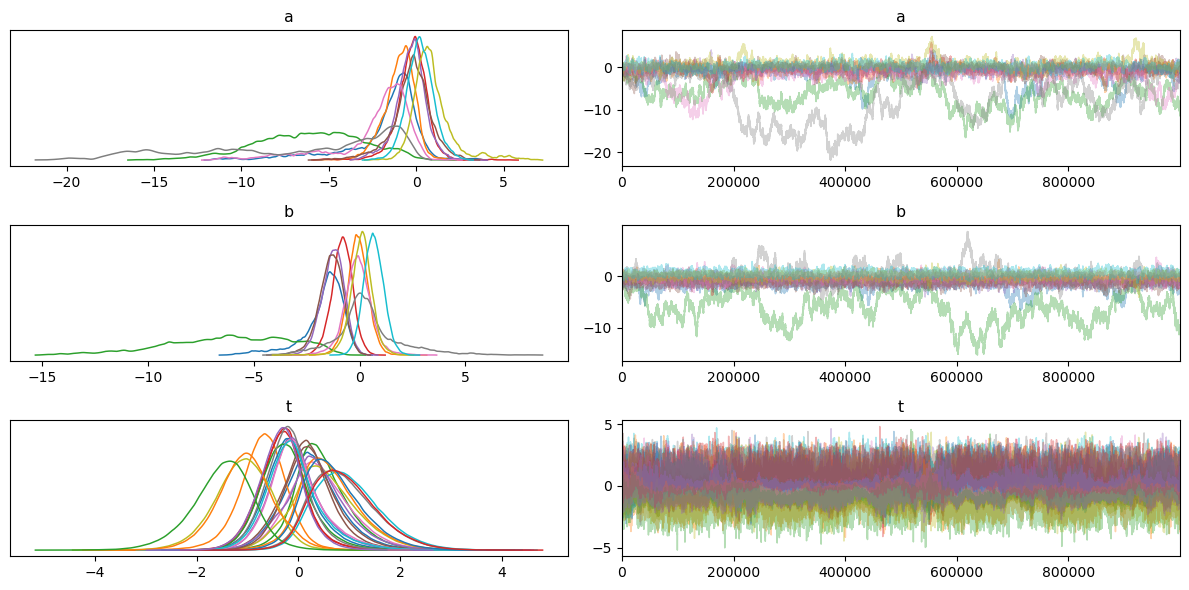

In [187]:
rng = np.random.default_rng(0)
P, I = 25, 10

# true parameters
true_a = rng.normal(0.5, 1.0, size=I)
true_b = rng.normal(0.0, 1.0, size=I)
true_theta = rng.normal(0.0, 1.0, size=P)

lin = np.outer(true_theta, true_a) + true_b[None, :]
prob = 1.0 / (1.0 + np.exp(-lin))
Y = (rng.uniform(size=(P, I)) < prob).astype(np.int32)

# create two different initializations for the two chains
# (same data Y for both chains; different starts)
a_init = (jnp.zeros(I), jnp.ones(I) * 2.0)   # chain0 zeros, chain1 2.0
b_init = (jnp.zeros(I), jnp.ones(I) * -2.0)
t_init = (jnp.zeros(P), jnp.ones(P) * 1.5)

# run the coupled sampler
n_iter = 1000000
prop_sd_a = 0.03
prop_sd_b = 0.03
prop_sd_t = 0.18
eta = 1.0  # set <1.0 to bound cost if desired

start_time = time()
traces, acc = run_coupled_mh_jitted(
    (Y, Y),
    n_iter=n_iter,
    prop_sd_a=prop_sd_a,
    prop_sd_b=prop_sd_b,
    prop_sd_t=prop_sd_t,
    a_init=a_init,
    b_init=b_init,
    t_init=t_init,
)
end_time = time()

print(f"Coupled MH sampler runtime: {end_time - start_time:.2f} seconds\n")

# acc is dict of tuples (chain0, chain1) each an array per-coordinate
print("Mean acceptance rates (chain 0):")
print(" mean acc a:", np.mean(acc['a'][0]))
print(" mean acc b:", np.mean(acc['b'][0]))
print(" mean acc t:", np.mean(acc['t'][0]))
print("\nMean acceptance rates (chain 1):")
print(" mean acc a:", np.mean(acc['a'][1]))
print(" mean acc b:", np.mean(acc['b'][1]))
print(" mean acc t:", np.mean(acc['t'][1]))

# Posterior means after burn-in (use chain 0 by default)
chain_idx = 0
a_tr = traces['a'][chain_idx]  # shape (n_iter, I)
b_tr = traces['b'][chain_idx]
t_tr = traces['t'][chain_idx]

a_hat = a_tr.mean(axis=0)
b_hat = b_tr.mean(axis=0)
theta_hat = t_tr.mean(axis=0)

print("\nPosterior means (first 5):")
print("a_hat[:5]:", a_hat[:5])
print("b_hat[:5]:", b_hat[:5])
print("theta_hat[:5]:", theta_hat[:5])

# Compare to truth
a_diff = a_hat - true_a
b_diff = b_hat - true_b
theta_diff = theta_hat - true_theta

print("\nDifferences (posterior mean - true value) first 5:")
print("a_diff[:5]:", a_diff[:5])
print("b_diff[:5]:", b_diff[:5])
print("theta_diff[:5]:", theta_diff[:5])

print("\nSummary of absolute differences:")
print("Mean abs error a:", np.mean(np.abs(a_diff)))
print("Mean abs error b:", np.mean(np.abs(b_diff)))
print("Mean abs error theta:", np.mean(np.abs(theta_diff)))
print("Max abs error a:", np.max(np.abs(a_diff)))
print("Max abs error b:", np.max(np.abs(b_diff)))
print("Max abs error theta:", np.max(np.abs(theta_diff)))

# --- Approximate meeting time (chains close enough) ---
tolerance = 1e-4
meeting_time = None

for it in range(n_iter):
    close_a = np.allclose(traces['a'][0, it, :], traces['a'][1, it, :], atol=tolerance)
    close_b = np.allclose(traces['b'][0, it, :], traces['b'][1, it, :], atol=tolerance)
    close_t = np.allclose(traces['t'][0, it, :], traces['t'][1, it, :], atol=tolerance)
    
    if close_a and close_b and close_t:
        meeting_time = it
        break

if meeting_time is not None:
    print(f"\nChains approximately met at iteration (0-based): {meeting_time}")
    
    # --- Safe slicing: ensure arrays are not empty ---
    post_meeting_slice = slice(meeting_time, None)
    
    # Posterior means after meeting (chain 0)
    chain_idx = 0
    a_tr = traces['a'][chain_idx][post_meeting_slice]
    b_tr = traces['b'][chain_idx][post_meeting_slice]
    t_tr = traces['t'][chain_idx][post_meeting_slice]

    # Posterior summaries
    a_hat = a_tr.mean(axis=0)
    b_hat = b_tr.mean(axis=0)
    theta_hat = t_tr.mean(axis=0)
    
    print("\nPosterior means (first 5) after meeting:")
    print("a_hat[:5]:", a_hat[:5])
    print("b_hat[:5]:", b_hat[:5])
    print("theta_hat[:5]:", theta_hat[:5])
    
    # Compare to truth
    a_diff = a_hat - true_a
    b_diff = b_hat - true_b
    theta_diff = theta_hat - true_theta
    
    print("\nDifferences (posterior mean - true value) first 5:")
    print("a_diff[:5]:", a_diff[:5])
    print("b_diff[:5]:", b_diff[:5])
    print("theta_diff[:5]:", theta_diff[:5])
    
    print("\nSummary of absolute differences:")
    print("Mean abs error a:", np.mean(np.abs(a_diff)))
    print("Mean abs error b:", np.mean(np.abs(b_diff)))
    print("Mean abs error theta:", np.mean(np.abs(theta_diff)))
    print("Max abs error a:", np.max(np.abs(a_diff)))
    print("Max abs error b:", np.max(np.abs(b_diff)))
    print("Max abs error theta:", np.max(np.abs(theta_diff)))

    # --- Acceptance rates ---
    # If your acc arrays are per-iteration, per-parameter:
    if isinstance(acc['a'][0], np.ndarray) and acc['a'][0].size >= meeting_time:
        print("\nMean acceptance rates after meeting (chain 0):")
        print(" mean acc a:", np.mean(acc['a'][0][post_meeting_slice]))
        print(" mean acc b:", np.mean(acc['b'][0][post_meeting_slice]))
        print(" mean acc t:", np.mean(acc['t'][0][post_meeting_slice]))
        print("\nMean acceptance rates after meeting (chain 1):")
        print(" mean acc a:", np.mean(acc['a'][1][post_meeting_slice]))
        print(" mean acc b:", np.mean(acc['b'][1][post_meeting_slice]))
        print(" mean acc t:", np.mean(acc['t'][1][post_meeting_slice]))
    else:
        print("\nAcceptance arrays not long enough; showing total acceptance rates instead:")
        print("acc (chain0):", {k: np.mean(v[0]) for k,v in acc.items()})
        print("acc (chain1):", {k: np.mean(v[1]) for k,v in acc.items()})
    
else:
    print("\nChains did NOT meet within the run (parameters not within tolerance).")

# Optional: ArviZ diagnostics / traceplot for chain 0
try:
    idata = az.from_dict(
        posterior={
            "a": traces['a'][chain_idx][None, :, :],  # shape (chain=1, draws, I)
            "b": traces['b'][chain_idx][None, :, :],
            "t": traces['t'][chain_idx][None, :, :],
        }
    )
    az.plot_trace(idata, var_names=["a", "b", "t"])
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("ArviZ plotting failed:", e)


#### Parameter Blocked Metropolis-Gibbs

In [107]:
# -------------------------
# Model log-joint
# -------------------------
variance = 100.0
sa = jnp.sqrt(variance)
sb = jnp.sqrt(variance)

@jit
def log_joint(a, b, t, Y):
    la = jnp.sum(jax.scipy.stats.norm.logpdf(a, 0., sa))
    lb = jnp.sum(jax.scipy.stats.norm.logpdf(b, 0., sb))
    lt = jnp.sum(jax.scipy.stats.norm.logpdf(t, 0., 1.))
    logits = jnp.outer(t, a) + b[None, :]
    lY = jnp.sum(Y * jax.nn.log_sigmoid(logits) + (1-Y) * jax.nn.log_sigmoid(-logits))
    return la + lb + lt + lY

# -------------------------
# Maximal coupling for multivariate Gaussian
# -------------------------
@jit
def maximal_coupling_mv_gauss(key, mu1, mu2, sd1, sd2):
    key, subkey = random.split(key)
    z = random.normal(subkey, shape=mu1.shape)
    prop1 = mu1 + z * sd1
    prop2 = mu2 + z * sd2
    return key, prop1, prop2

# -------------------------
# Single MH block update
# -------------------------
@jit
def mh_block_update(key, a1, a2, b1, b2, t1, t2, Y1, Y2,
                    prop_sd_a, prop_sd_b, prop_sd_t,
                    curr_lp1, curr_lp2):

    # a-block
    key, prop_a1, prop_a2 = maximal_coupling_mv_gauss(key, a1, a2, prop_sd_a, prop_sd_a)
    lp_prop1 = log_joint(prop_a1, b1, t1, Y1)
    lp_prop2 = log_joint(prop_a2, b2, t2, Y2)
    key, subkey = random.split(key)
    log_u = jnp.log(random.uniform(subkey))
    accept1 = log_u < (lp_prop1 - curr_lp1)
    accept2 = log_u < (lp_prop2 - curr_lp2)
    a1 = jax.lax.select(accept1, prop_a1, a1)
    a2 = jax.lax.select(accept2, prop_a2, a2)
    curr_lp1 = jax.lax.select(accept1, lp_prop1, curr_lp1)
    curr_lp2 = jax.lax.select(accept2, lp_prop2, curr_lp2)
    acc_a1 = accept1.astype(jnp.int32)
    acc_a2 = accept2.astype(jnp.int32)

    # b-block
    key, prop_b1, prop_b2 = maximal_coupling_mv_gauss(key, b1, b2, prop_sd_b, prop_sd_b)
    lp_prop1 = log_joint(a1, prop_b1, t1, Y1)
    lp_prop2 = log_joint(a2, prop_b2, t2, Y2)
    key, subkey = random.split(key)
    log_u = jnp.log(random.uniform(subkey))
    accept1 = log_u < (lp_prop1 - curr_lp1)
    accept2 = log_u < (lp_prop2 - curr_lp2)
    b1 = jax.lax.select(accept1, prop_b1, b1)
    b2 = jax.lax.select(accept2, prop_b2, b2)
    curr_lp1 = jax.lax.select(accept1, lp_prop1, curr_lp1)
    curr_lp2 = jax.lax.select(accept2, lp_prop2, curr_lp2)
    acc_b1 = accept1.astype(jnp.int32)
    acc_b2 = accept2.astype(jnp.int32)

    # t-block
    key, prop_t1, prop_t2 = maximal_coupling_mv_gauss(key, t1, t2, prop_sd_t, prop_sd_t)
    lp_prop1 = log_joint(a1, b1, prop_t1, Y1)
    lp_prop2 = log_joint(a2, b2, prop_t2, Y2)
    key, subkey = random.split(key)
    log_u = jnp.log(random.uniform(subkey))
    accept1 = log_u < (lp_prop1 - curr_lp1)
    accept2 = log_u < (lp_prop2 - curr_lp2)
    t1 = jax.lax.select(accept1, prop_t1, t1)
    t2 = jax.lax.select(accept2, prop_t2, t2)
    curr_lp1 = jax.lax.select(accept1, lp_prop1, curr_lp1)
    curr_lp2 = jax.lax.select(accept2, lp_prop2, curr_lp2)
    acc_t1 = accept1.astype(jnp.int32)
    acc_t2 = accept2.astype(jnp.int32)

    return key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2, acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2

# -------------------------
# Fully JITted blocked coupled sampler
# -------------------------
def run_coupled_mh_blocked(Y_pair, n_iter=2000,
                           prop_sd_a=0.5, prop_sd_b=0.5, prop_sd_t=0.2,
                           a_init=None, b_init=None, t_init=None,
                           rng_seed=0):
    Y1 = jnp.asarray(Y_pair[0])
    Y2 = jnp.asarray(Y_pair[1])
    P, I = Y1.shape

    a1 = jnp.zeros(I) if a_init is None else jnp.asarray(a_init[0])
    a2 = jnp.zeros(I) if a_init is None else jnp.asarray(a_init[1])
    b1 = jnp.zeros(I) if b_init is None else jnp.asarray(b_init[0])
    b2 = jnp.zeros(I) if b_init is None else jnp.asarray(b_init[1])
    t1 = jnp.zeros(P) if t_init is None else jnp.asarray(t_init[0])
    t2 = jnp.zeros(P) if t_init is None else jnp.asarray(t_init[1])

    trace_a = jnp.zeros((2, n_iter, I))
    trace_b = jnp.zeros((2, n_iter, I))
    trace_t = jnp.zeros((2, n_iter, P))

    acc_a1 = jnp.zeros(I, dtype=jnp.int32)
    acc_a2 = jnp.zeros(I, dtype=jnp.int32)
    acc_b1 = jnp.zeros(I, dtype=jnp.int32)
    acc_b2 = jnp.zeros(I, dtype=jnp.int32)
    acc_t1 = jnp.zeros(P, dtype=jnp.int32)
    acc_t2 = jnp.zeros(P, dtype=jnp.int32)

    key = random.PRNGKey(rng_seed)
    curr_lp1 = log_joint(a1, b1, t1, Y1)
    curr_lp2 = log_joint(a2, b2, t2, Y2)

    def body(it, carry):
        key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2, trace_a, trace_b, trace_t, acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2 = carry

        key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2, aa1, aa2, bb1, bb2, tt1, tt2 = \
            mh_block_update(key, a1, a2, b1, b2, t1, t2, Y1, Y2,
                            prop_sd_a, prop_sd_b, prop_sd_t,
                            curr_lp1, curr_lp2)

        trace_a = trace_a.at[0, it, :].set(a1)
        trace_a = trace_a.at[1, it, :].set(a2)
        trace_b = trace_b.at[0, it, :].set(b1)
        trace_b = trace_b.at[1, it, :].set(b2)
        trace_t = trace_t.at[0, it, :].set(t1)
        trace_t = trace_t.at[1, it, :].set(t2)

        acc_a1 += aa1
        acc_a2 += aa2
        acc_b1 += bb1
        acc_b2 += bb2
        acc_t1 += tt1
        acc_t2 += tt2

        return key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2, trace_a, trace_b, trace_t, acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2

    carry0 = (key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2,
              trace_a, trace_b, trace_t, acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2)

    carry_final = lax.fori_loop(0, n_iter, body, carry0)

    _, _, _, _, _, _, _, _, _, trace_a, trace_b, trace_t, acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2 = carry_final

    traces = {'a': np.array(trace_a), 'b': np.array(trace_b), 't': np.array(trace_t)}
    acc_rates = {
        'a': (np.array(acc_a1)/n_iter, np.array(acc_a2)/n_iter),
        'b': (np.array(acc_b1)/n_iter, np.array(acc_b2)/n_iter),
        't': (np.array(acc_t1)/n_iter, np.array(acc_t2)/n_iter),
    }
    return traces, acc_rates


Coupled MH sampler runtime: 66.72 seconds

Mean acceptance rates (chain 0):
 mean acc a: 0.9449080000000001
 mean acc b: 0.925972
 mean acc t: 0.223243

Mean acceptance rates (chain 1):
 mean acc a: 0.943922
 mean acc b: 0.926128
 mean acc t: 0.20432299999999998

Posterior means (first 5):
a_hat[:5]: [-3.526008   -3.1504343  -4.7206206  -0.45162556 -0.4264368 ]
b_hat[:5]: [-2.6572883  -0.43358335 -4.6840124  -0.89480424 -1.3257104 ]
theta_hat[:5]: [ 8.9685582e-03 -8.4824538e-01  2.6214930e-01  3.2740725e-05
  1.7455024e-01]

Differences (posterior mean - true value) first 5:
a_diff[:5]: [-4.15173811 -3.51832939 -5.86104328 -1.05652567 -0.39076744]
b_diff[:5]: [-2.03401385 -0.47490933 -2.35898164 -0.67601258 -0.07979947]
theta_diff[:5]: [ 0.13750322 -2.21470885  0.92734398 -0.35147733 -0.72891995]

Summary of absolute differences:
Mean abs error a: 2.659616175848434
Mean abs error b: 0.798353268627521
Mean abs error theta: 0.9580307093152985
Max abs error a: 5.861043282614913
Max abs er

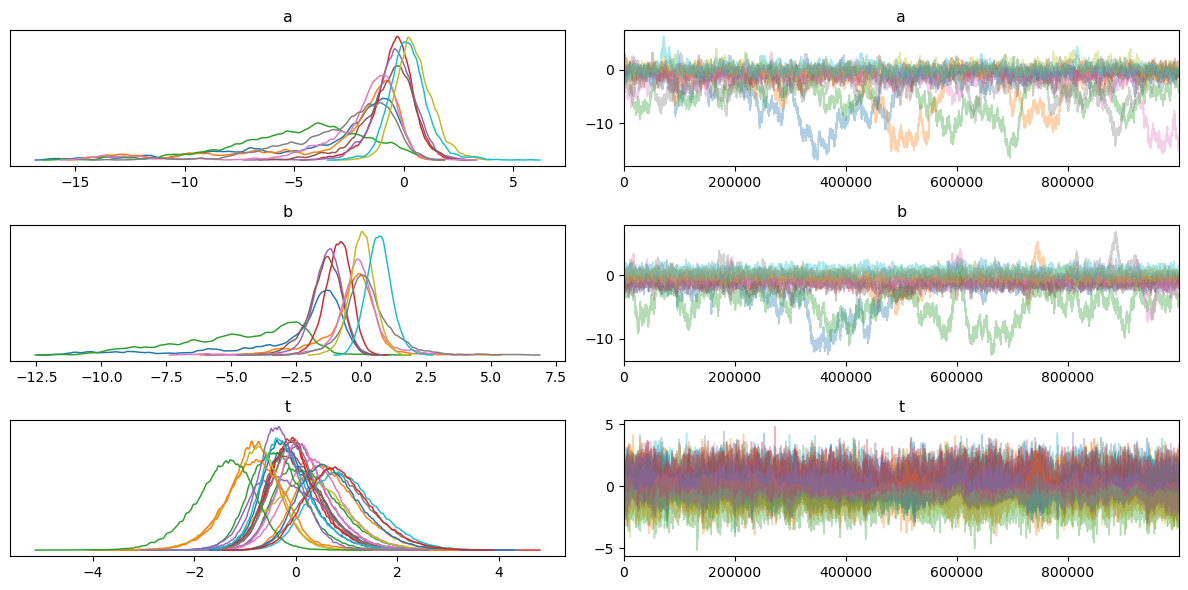

In [188]:
rng = np.random.default_rng(0)
P, I = 25, 10

# true parameters
true_a = rng.normal(0.5, 1.0, size=I)
true_b = rng.normal(0.0, 1.0, size=I)
true_theta = rng.normal(0.0, 1.0, size=P)

lin = np.outer(true_theta, true_a) + true_b[None, :]
prob = 1.0 / (1.0 + np.exp(-lin))
Y = (rng.uniform(size=(P, I)) < prob).astype(np.int32)

# create two different initializations for the two chains
# (same data Y for both chains; different starts)
a_init = (jnp.zeros(I), jnp.ones(I) * 2.0)   # chain0 zeros, chain1 2.0
b_init = (jnp.zeros(I), jnp.ones(I) * -2.0)
t_init = (jnp.zeros(P), jnp.ones(P) * 1.5)

# run the coupled sampler
n_iter = 1000000
prop_sd_a = 0.03
prop_sd_b = 0.03
prop_sd_t = 0.18
eta = 1.0  # set <1.0 to bound cost if desired

start_time = time()
traces, acc = run_coupled_mh_blocked(
    (Y, Y),
    n_iter=n_iter,
    prop_sd_a=prop_sd_a,
    prop_sd_b=prop_sd_b,
    prop_sd_t=prop_sd_t,
    a_init=a_init,
    b_init=b_init,
    t_init=t_init,
)
end_time = time()

print(f"Coupled MH sampler runtime: {end_time - start_time:.2f} seconds\n")

# acc is dict of tuples (chain0, chain1) each an array per-coordinate
print("Mean acceptance rates (chain 0):")
print(" mean acc a:", np.mean(acc['a'][0]))
print(" mean acc b:", np.mean(acc['b'][0]))
print(" mean acc t:", np.mean(acc['t'][0]))
print("\nMean acceptance rates (chain 1):")
print(" mean acc a:", np.mean(acc['a'][1]))
print(" mean acc b:", np.mean(acc['b'][1]))
print(" mean acc t:", np.mean(acc['t'][1]))

# Posterior means after burn-in (use chain 0 by default)
chain_idx = 0
a_tr = traces['a'][chain_idx]  # shape (n_iter, I)
b_tr = traces['b'][chain_idx]
t_tr = traces['t'][chain_idx]

a_hat = a_tr.mean(axis=0)
b_hat = b_tr.mean(axis=0)
theta_hat = t_tr.mean(axis=0)

print("\nPosterior means (first 5):")
print("a_hat[:5]:", a_hat[:5])
print("b_hat[:5]:", b_hat[:5])
print("theta_hat[:5]:", theta_hat[:5])

# Compare to truth
a_diff = a_hat - true_a
b_diff = b_hat - true_b
theta_diff = theta_hat - true_theta

print("\nDifferences (posterior mean - true value) first 5:")
print("a_diff[:5]:", a_diff[:5])
print("b_diff[:5]:", b_diff[:5])
print("theta_diff[:5]:", theta_diff[:5])

print("\nSummary of absolute differences:")
print("Mean abs error a:", np.mean(np.abs(a_diff)))
print("Mean abs error b:", np.mean(np.abs(b_diff)))
print("Mean abs error theta:", np.mean(np.abs(theta_diff)))
print("Max abs error a:", np.max(np.abs(a_diff)))
print("Max abs error b:", np.max(np.abs(b_diff)))
print("Max abs error theta:", np.max(np.abs(theta_diff)))

# --- Approximate meeting time (chains close enough) ---
tolerance = 1e-4
meeting_time = None

for it in range(n_iter):
    close_a = np.allclose(traces['a'][0, it, :], traces['a'][1, it, :], atol=tolerance)
    close_b = np.allclose(traces['b'][0, it, :], traces['b'][1, it, :], atol=tolerance)
    close_t = np.allclose(traces['t'][0, it, :], traces['t'][1, it, :], atol=tolerance)
    
    if close_a and close_b and close_t:
        meeting_time = it
        break

if meeting_time is not None:
    print(f"\nChains approximately met at iteration (0-based): {meeting_time}")
    
    # --- Safe slicing: ensure arrays are not empty ---
    post_meeting_slice = slice(meeting_time, None)
    
    # Posterior means after meeting (chain 0)
    chain_idx = 0
    a_tr = traces['a'][chain_idx][post_meeting_slice]
    b_tr = traces['b'][chain_idx][post_meeting_slice]
    t_tr = traces['t'][chain_idx][post_meeting_slice]

    # Posterior summaries
    a_hat = a_tr.mean(axis=0)
    b_hat = b_tr.mean(axis=0)
    theta_hat = t_tr.mean(axis=0)
    
    print("\nPosterior means (first 5) after meeting:")
    print("a_hat[:5]:", a_hat[:5])
    print("b_hat[:5]:", b_hat[:5])
    print("theta_hat[:5]:", theta_hat[:5])
    
    # Compare to truth
    a_diff = a_hat - true_a
    b_diff = b_hat - true_b
    theta_diff = theta_hat - true_theta
    
    print("\nDifferences (posterior mean - true value) first 5:")
    print("a_diff[:5]:", a_diff[:5])
    print("b_diff[:5]:", b_diff[:5])
    print("theta_diff[:5]:", theta_diff[:5])
    
    print("\nSummary of absolute differences:")
    print("Mean abs error a:", np.mean(np.abs(a_diff)))
    print("Mean abs error b:", np.mean(np.abs(b_diff)))
    print("Mean abs error theta:", np.mean(np.abs(theta_diff)))
    print("Max abs error a:", np.max(np.abs(a_diff)))
    print("Max abs error b:", np.max(np.abs(b_diff)))
    print("Max abs error theta:", np.max(np.abs(theta_diff)))

    # --- Acceptance rates ---
    # If your acc arrays are per-iteration, per-parameter:
    if isinstance(acc['a'][0], np.ndarray) and acc['a'][0].size >= meeting_time:
        print("\nMean acceptance rates after meeting (chain 0):")
        print(" mean acc a:", np.mean(acc['a'][0][post_meeting_slice]))
        print(" mean acc b:", np.mean(acc['b'][0][post_meeting_slice]))
        print(" mean acc t:", np.mean(acc['t'][0][post_meeting_slice]))
        print("\nMean acceptance rates after meeting (chain 1):")
        print(" mean acc a:", np.mean(acc['a'][1][post_meeting_slice]))
        print(" mean acc b:", np.mean(acc['b'][1][post_meeting_slice]))
        print(" mean acc t:", np.mean(acc['t'][1][post_meeting_slice]))
    else:
        print("\nAcceptance arrays not long enough; showing total acceptance rates instead:")
        print("acc (chain0):", {k: np.mean(v[0]) for k,v in acc.items()})
        print("acc (chain1):", {k: np.mean(v[1]) for k,v in acc.items()})
    
else:
    print("\nChains did NOT meet within the run (parameters not within tolerance).")

    
# Optional: ArviZ diagnostics / traceplot for chain 0
try:
    idata = az.from_dict(
        posterior={
            "a": traces['a'][chain_idx][None, :, :],  # shape (chain=1, draws, I)
            "b": traces['b'][chain_idx][None, :, :],
            "t": traces['t'][chain_idx][None, :, :],
        }
    )
    az.plot_trace(idata, var_names=["a", "b", "t"])
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("ArviZ plotting failed:", e)


## Reflective Coupling

A coupling for distributions $p$ and $q$ obtained from a common spherically symmetric distribution $s$, rescaled with a common covariance $\Sigma$, and shifted by $\mu_1$ and $\mu_2$ respectively. For example $p = N(\mu_1, \Sigma)$ and $q = N(\mu_2, \Sigma)$ if $s = N(0, I)$.

1. Let $\Delta = \Sigma^{-\frac{1}{2}}(\mu_1 - \mu_2)$ and $e = \frac{\Delta}{|\Delta|}$ where $|\cdot|$ is the $L_2$ norm.

2. Sample $\tilde{X} \sim s$, and $W \sim Unif(0, 1)$.

    (a) If $s(\tilde{X})W \leq s(\tilde{X} + \Delta)$, set $\tilde{Y} = \tilde{X} + \Delta$.


    (b) Else set $\tilde{Y} = \tilde{X} - 2(e^T\tilde{X})e$

4. Set $X = \Sigma^{\frac{1}{2}}\tilde{X} + \mu_1$, $Y = \Sigma^{\frac{1}{2}}\tilde{Y} + \mu_2$, and return $(X, Y)$.

### Standard Pythonic Loops

#### Parameter Blocked Metropolis-Hastings

In [111]:
variance = 100

sa = jnp.sqrt(variance)
sb = jnp.sqrt(variance)

def log_joint(a, b, t, Y):
    la = jnp.sum(dist.Normal(0, sa).log_prob(a))
    lb = jnp.sum(dist.Normal(0, sb).log_prob(b))
    lt = jnp.sum(dist.Normal(0, 1).log_prob(t))

    pi_val = jnp.outer(t, a) + b[None, :]
    
    lY = jnp.sum(dist.Bernoulli(logits=pi_val).log_prob(Y))

    return la + lb + lt + lY


def reflective_coupling_proposal(key, mu1, mu2, cov):
    L = jnp.linalg.cholesky(cov) 
    Delta = mu1 - mu2
    e = Delta / jnp.linalg.norm(Delta)

    key, subkey = random.split(key)
    x = random.normal(subkey, shape=mu1.shape)  

    key, subkey = random.split(key)
    log_u = jnp.log(random.uniform(subkey))

    log_ratio = jnp.sum(dist.Normal(0, 1).log_prob(x + Delta) - dist.Normal(0, 1).log_prob(x))
    
    def accept(x):
        return x + Delta
    def reflect(x):
        return x - 2 * (e @ x) * e

    y = lax.cond(log_u <= log_ratio, accept, reflect, x)

    prop1 = mu1 + L @ x
    prop2 = mu2 + L @ y
    return key, prop1, prop2

def mh_block_step_reflective_couple(key, x1, x2, joint1, joint2, prop_cov, clp1, clp2, acc1, acc2):
    key, prop1, prop2 = reflective_coupling_proposal(key, x1, x2, prop_cov)

    x_prop1 = prop1
    x_prop2 = prop2

    lp_prop1 = float(joint1(x_prop1))
    lp_prop2 = float(joint2(x_prop2))

    log_alpha1 = lp_prop1 - clp1
    log_alpha2 = lp_prop2 - clp2

    key, subkey = jax.random.split(key)

    log_u = jnp.log(jax.random.uniform(subkey))

    if log_u < log_alpha1:
        x1 = x_prop1
        clp1 = lp_prop1
        acc1 += 1

    if log_u < log_alpha2:
        x2 = x_prop2
        clp2 = lp_prop2
        acc2 += 1

    return key, x1, x2, clp1, clp2, acc1, acc2

def mh_block_reflective_couple(Y, n_iter = 2000, prop_sd_a = 0.5, prop_sd_b = 0.5, prop_sd_t = 0.2, a_init = None, b_init = None, t_init = None):

    Y1 = jnp.asarray(Y[0])
    Y2 = jnp.asarray(Y[1])
    
    P, I = Y1.shape

    if a_init is None:
        a1 = jnp.zeros(I)
        a2 = jnp.zeros(I)
        
    else:
        a1 = jnp.asarray(a_init[0])
        a2 = jnp.asarray(a_init[1])
        
    if b_init is None:
        b1 = jnp.zeros(I)
        b2 = jnp.zeros(I)
        
    else:
        b1 = jnp.asarray(b_init[0])
        b2 = jnp.asarray(b_init[1])
        
    if t_init is None:
        t1 = jnp.zeros(P)
        t2 = jnp.zeros(P)
        
    else:
        t1 = jnp.asarray(t_init[0])
        t2 = jnp.asarray(t_init[1])

    trace_a = np.zeros((2, n_iter, I), dtype=float)
    trace_b = np.zeros((2, n_iter, I), dtype=float)
    trace_t = np.zeros((2, n_iter, P), dtype=float)

    acc_a1 = 0
    acc_b1 = 0
    acc_t1 = 0

    acc_a2 = 0
    acc_b2 = 0
    acc_t2 = 0

    key = jax.random.PRNGKey(0)

    curr_lp1 = float(log_joint(a1, b1, t1, Y1))
    curr_lp2 = float(log_joint(a2, b2, t2, Y2))

    for it in range(n_iter):
        joint1 = lambda x: log_joint(x, b1, t1, Y1)
        joint2 = lambda x: log_joint(x, b2, t2, Y2)

        key, a1, a2, curr_lp1, curr_lp2, acc_a1, acc_a2 = mh_block_step_reflective_couple(key, a1, a2, joint1, joint2, prop_sd_a**2 * jnp.diag(jnp.ones(a1.shape)), curr_lp1, curr_lp2, acc_a1, acc_a2)

        joint1 = lambda x: log_joint(a1, x, t1, Y1)
        joint2 = lambda x: log_joint(a2, x, t2, Y2)

        key, b1, b2, curr_lp1, curr_lp2, acc_b1, acc_b2 = mh_block_step_reflective_couple(key, b1, b2, joint1, joint2, prop_sd_b**2 * jnp.diag(jnp.ones(b1.shape)), curr_lp1, curr_lp2, acc_b1, acc_b2)

        joint1 = lambda x: log_joint(a1, b1, x, Y1)
        joint2 = lambda x: log_joint(a2, b2, x, Y2)

        key, t1, t2, curr_lp1, curr_lp2, acc_t1, acc_t2 = mh_block_step_reflective_couple(key, t1, t2, joint1, joint2, prop_sd_t**2 * jnp.diag(jnp.ones(t1.shape)), curr_lp1, curr_lp2, acc_t1, acc_t2)

        trace_a[0, it, :] = np.array(a1)
        trace_a[1, it, :] = np.array(a2)
        trace_b[0, it, :] = np.array(b1)
        trace_b[1, it, :] = np.array(b2)
        trace_t[0, it, :] = np.array(t1)
        trace_t[1, it, :] = np.array(t2)

    traces = {'a': trace_a, 'b': trace_b, 't': trace_t}

    acc_rates = {
        'a': (acc_a1 / float(n_iter), acc_a2 / float(n_iter)),
        'b': (acc_b1 / float(n_iter), acc_b2 / float(n_iter)),
        't': (acc_t1 / float(n_iter), acc_t2 / float(n_iter)),
    }
    
    return traces, acc_rates
    

Coupled MH sampler runtime: 120.17 seconds

Mean acceptance rates (chain 0):
 mean acc a: 0.6335
 mean acc b: 0.592
 mean acc t: 0.078

Mean acceptance rates (chain 1):
 mean acc a: 0.6305
 mean acc b: 0.595
 mean acc t: 0.057

Posterior means (first 5):
a_hat[:5]: [ 0.33409595 -0.03532476  2.78960448  0.15525414 -0.31160032]
b_hat[:5]: [-1.24377887 -0.21955659 -4.4353752  -0.72295533 -1.23761816]
theta_hat[:5]: [-0.27172208  0.23958484 -0.47309377  0.31338017  0.5918078 ]

Differences (posterior mean - true value) first 5:
a_diff[:5]: [-0.29163427 -0.4032199   1.64918183 -0.44964598 -0.27593095]
b_diff[:5]: [-0.62050441 -0.26088257 -2.11034443 -0.50416367  0.00829278]
theta_diff[:5]: [-0.14318742 -1.12687864  0.19210091 -0.0381299  -0.31166238]

Summary of absolute differences:
Mean abs error a: 0.6613794831973894
Mean abs error b: 0.5232413634004593
Mean abs error theta: 0.5650385818082273
Max abs error a: 1.649181834375594
Max abs error b: 2.110344425301221
Max abs error theta: 1.25

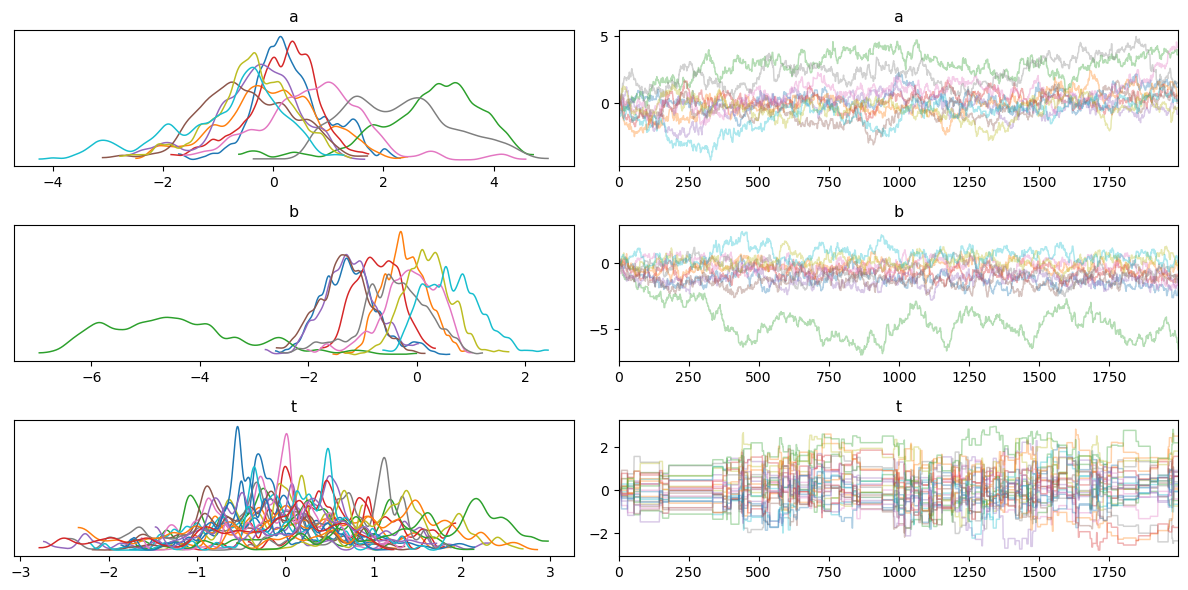

In [110]:
rng = np.random.default_rng(0)
P, I = 25, 10

# true parameters
true_a = rng.normal(0.5, 1.0, size=I)
true_b = rng.normal(0.0, 1.0, size=I)
true_theta = rng.normal(0.0, 1.0, size=P)

lin = np.outer(true_theta, true_a) + true_b[None, :]
prob = 1.0 / (1.0 + np.exp(-lin))
Y = (rng.uniform(size=(P, I)) < prob).astype(np.int32)

# create two different initializations for the two chains
# (same data Y for both chains; different starts)
a_init = (jnp.zeros(I), jnp.ones(I) * 2.0)   # chain0 zeros, chain1 2.0
b_init = (jnp.zeros(I), jnp.ones(I) * -2.0)
t_init = (jnp.zeros(P), jnp.ones(P) * 1.5)

# run the coupled sampler
n_iter = 2000
prop_sd_a = 0.03
prop_sd_b = 0.03
prop_sd_t = 0.18
eta = 1.0  # set <1.0 to bound cost if desired

start_time = time()
traces, acc = mh_block_reflective_couple(
    (Y, Y),
    n_iter=n_iter,
    prop_sd_a=prop_sd_a,
    prop_sd_b=prop_sd_b,
    prop_sd_t=prop_sd_t,
    a_init=a_init,
    b_init=b_init,
    t_init=t_init,
)
end_time = time()

print(f"Coupled MH sampler runtime: {end_time - start_time:.2f} seconds\n")

# acc is dict of tuples (chain0, chain1) each an array per-coordinate
print("Mean acceptance rates (chain 0):")
print(" mean acc a:", np.mean(acc['a'][0]))
print(" mean acc b:", np.mean(acc['b'][0]))
print(" mean acc t:", np.mean(acc['t'][0]))
print("\nMean acceptance rates (chain 1):")
print(" mean acc a:", np.mean(acc['a'][1]))
print(" mean acc b:", np.mean(acc['b'][1]))
print(" mean acc t:", np.mean(acc['t'][1]))

# Posterior means after burn-in (use chain 0 by default)
chain_idx = 0
a_tr = traces['a'][chain_idx]  # shape (n_iter, I)
b_tr = traces['b'][chain_idx]
t_tr = traces['t'][chain_idx]

a_hat = a_tr.mean(axis=0)
b_hat = b_tr.mean(axis=0)
theta_hat = t_tr.mean(axis=0)

print("\nPosterior means (first 5):")
print("a_hat[:5]:", a_hat[:5])
print("b_hat[:5]:", b_hat[:5])
print("theta_hat[:5]:", theta_hat[:5])

# Compare to truth
a_diff = a_hat - true_a
b_diff = b_hat - true_b
theta_diff = theta_hat - true_theta

print("\nDifferences (posterior mean - true value) first 5:")
print("a_diff[:5]:", a_diff[:5])
print("b_diff[:5]:", b_diff[:5])
print("theta_diff[:5]:", theta_diff[:5])

print("\nSummary of absolute differences:")
print("Mean abs error a:", np.mean(np.abs(a_diff)))
print("Mean abs error b:", np.mean(np.abs(b_diff)))
print("Mean abs error theta:", np.mean(np.abs(theta_diff)))
print("Max abs error a:", np.max(np.abs(a_diff)))
print("Max abs error b:", np.max(np.abs(b_diff)))
print("Max abs error theta:", np.max(np.abs(theta_diff)))

# --- Approximate meeting time (chains close enough) ---
tolerance = 1e-4  # adjust as needed
meeting_time = None

for it in range(n_iter):
    close_a = np.allclose(traces['a'][0, it, :], traces['a'][1, it, :], atol=tolerance)
    close_b = np.allclose(traces['b'][0, it, :], traces['b'][1, it, :], atol=tolerance)
    close_t = np.allclose(traces['t'][0, it, :], traces['t'][1, it, :], atol=tolerance)
    
    if close_a and close_b and close_t:
        meeting_time = it
        break

if meeting_time is not None:
    print(f"\nChains approximately met at iteration (0-based): {meeting_time}")
else:
    print("\nChains did NOT meet within the run (parameters not within tolerance).")

# Optional: ArviZ diagnostics / traceplot for chain 0
try:
    idata = az.from_dict(
        posterior={
            "a": traces['a'][chain_idx][None, :, :],  # shape (chain=1, draws, I)
            "b": traces['b'][chain_idx][None, :, :],
            "t": traces['t'][chain_idx][None, :, :],
        }
    )
    az.plot_trace(idata, var_names=["a", "b", "t"])
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("ArviZ plotting failed:", e)


#### Fully Blocked Metropolis-Hastings

In [158]:
variance = 100
sa = jnp.sqrt(variance)
sb = jnp.sqrt(variance)

# ------------------------
# Log joint using numpyro distributions
# ------------------------
import numpyro.distributions as dist

def log_joint(a, b, t, Y):
    la = jnp.sum(dist.Normal(0, sa).log_prob(a))
    lb = jnp.sum(dist.Normal(0, sb).log_prob(b))
    lt = jnp.sum(dist.Normal(0, 1).log_prob(t))

    pi_val = jnp.outer(t, a) + b[None, :]
    lY = jnp.sum(dist.Bernoulli(logits=pi_val).log_prob(Y))
    return la + lb + lt + lY


# ------------------------
# Reflective coupling proposal
# ------------------------
def reflective_coupling_proposal(key, mu1, mu2, cov):
    L = jnp.linalg.cholesky(cov)
    Delta = mu1 - mu2
    e = Delta / jnp.linalg.norm(Delta + 1e-16)  # avoid divide by zero

    key, subkey = random.split(key)
    x = random.normal(subkey, shape=mu1.shape)

    key, subkey = random.split(key)
    log_u = jnp.log(random.uniform(subkey))

    log_ratio = jnp.sum(norm.logpdf(x + Delta) - norm.logpdf(x))

    y = lax.cond(log_u <= log_ratio,
                 lambda x: x + Delta,
                 lambda x: x - 2 * (e @ x) * e,
                 x)

    prop1 = mu1 + L @ x
    prop2 = mu2 + L @ y
    return key, prop1, prop2


# ------------------------
# MH step for the joint block
# ------------------------
def mh_block_step_reflective_couple(key, x1, x2, joint1, joint2, prop_cov, clp1, clp2, acc1, acc2):
    key, prop1, prop2 = reflective_coupling_proposal(key, x1, x2, prop_cov)

    lp_prop1 = float(joint1(prop1))
    lp_prop2 = float(joint2(prop2))

    log_alpha1 = lp_prop1 - clp1
    log_alpha2 = lp_prop2 - clp2

    key, subkey = jax.random.split(key)
    log_u = jnp.log(jax.random.uniform(subkey))

    if log_u < log_alpha1:
        x1 = prop1
        clp1 = lp_prop1
        acc1 += 1

    if log_u < log_alpha2:
        x2 = prop2
        clp2 = lp_prop2
        acc2 += 1

    return key, x1, x2, clp1, clp2, acc1, acc2


# ------------------------
# Full block reflective coupled sampler (single accept counter)
# ------------------------
def mh_full_block_reflective_couple_single_accept(Y, n_iter=2000, prop_cov=None, a_init=None, b_init=None, t_init=None):
    Y1 = jnp.asarray(Y[0])
    Y2 = jnp.asarray(Y[1])
    
    P, I = Y1.shape

    if a_init is None:
        a1 = jnp.zeros(I)
        a2 = jnp.zeros(I)
    else:
        a1 = jnp.asarray(a_init[0])
        a2 = jnp.asarray(a_init[1])
        
    if b_init is None:
        b1 = jnp.zeros(I)
        b2 = jnp.zeros(I)
    else:
        b1 = jnp.asarray(b_init[0])
        b2 = jnp.asarray(b_init[1])
        
    if t_init is None:
        t1 = jnp.zeros(P)
        t2 = jnp.zeros(P)
    else:
        t1 = jnp.asarray(t_init[0])
        t2 = jnp.asarray(t_init[1])

    D = I*2 + P  # total dimension of (a,b,t)
    if prop_cov is None:
        prop_cov = jnp.eye(D) * 0.01  # default small diagonal if none provided

    trace_a = np.zeros((2, n_iter, I), dtype=float)
    trace_b = np.zeros((2, n_iter, I), dtype=float)
    trace_t = np.zeros((2, n_iter, P), dtype=float)

    acc = 0  # single counter

    key = random.PRNGKey(0)
    curr_lp1 = float(log_joint(a1, b1, t1, Y1))
    curr_lp2 = float(log_joint(a2, b2, t2, Y2))

    for it in range(n_iter):
        params1 = jnp.concatenate([a1, b1, t1])
        params2 = jnp.concatenate([a2, b2, t2])

        joint1 = lambda x: log_joint(x[:I], x[I:2*I], x[2*I:], Y1)
        joint2 = lambda x: log_joint(x[:I], x[I:2*I], x[2*I:], Y2)

        key, params1, params2, curr_lp1, curr_lp2, acc1, acc2 = mh_block_step_reflective_couple(
            key, params1, params2, joint1, joint2, prop_cov, curr_lp1, curr_lp2, acc, acc
        )

        # update joint parameters
        a1 = params1[:I]; b1 = params1[I:2*I]; t1 = params1[2*I:]
        a2 = params2[:I]; b2 = params2[I:2*I]; t2 = params2[2*I:]

        # store traces
        trace_a[0, it, :] = np.array(a1)
        trace_a[1, it, :] = np.array(a2)
        trace_b[0, it, :] = np.array(b1)
        trace_b[1, it, :] = np.array(b2)
        trace_t[0, it, :] = np.array(t1)
        trace_t[1, it, :] = np.array(t2)

        # update single accept counter
        acc = acc1  # same counter for both chains

    traces = {'a': trace_a, 'b': trace_b, 't': trace_t}
    acc_rate = acc / n_iter
    return traces, acc_rate



##### Testing with independent proposals

Coupled MH sampler runtime: 42.08 seconds

Mean acceptance rate (joint block): 0.581

Posterior means (first 5):
a_hat[:5]: [-0.50811734 -0.06774744 -0.27273322 -0.44537651 -0.18270546]
b_hat[:5]: [-0.73400841 -0.29672546 -1.02508966 -0.25886356 -0.40286331]
theta_hat[:5]: [ 0.39061795 -0.90993677  0.47385805  0.29360858  0.34306949]

Differences (posterior mean - true value) first 5:
a_diff[:5]: [-1.13384756 -0.43564258 -1.41315587 -1.05027663 -0.14703609]
b_diff[:5]: [-0.11073395 -0.33805144  1.29994111 -0.04007189  0.84304763]
theta_diff[:5]: [ 0.51915262 -2.27640024  1.13905272 -0.05790149 -0.56040069]

Summary of absolute differences:
Mean abs error a: 0.9817732731848509
Mean abs error b: 0.5094956143687093
Mean abs error theta: 0.8763326502749584
Max abs error a: 1.779277466404185
Max abs error b: 1.2999411100138305
Max abs error theta: 2.276400241633309

Chains did NOT meet within the run (parameters not within tolerance).


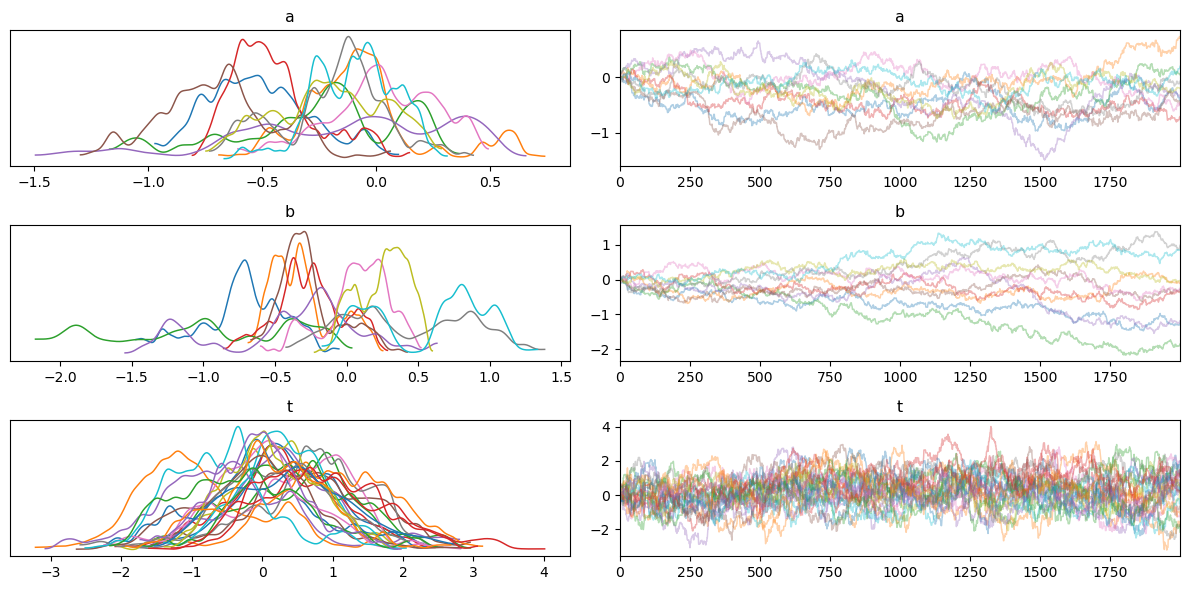

In [160]:
rng = np.random.default_rng(0)
P, I = 25, 10

# true parameters
true_a = rng.normal(0.5, 1.0, size=I)
true_b = rng.normal(0.0, 1.0, size=I)
true_theta = rng.normal(0.0, 1.0, size=P)

lin = np.outer(true_theta, true_a) + true_b[None, :]
prob = 1.0 / (1.0 + np.exp(-lin))
Y = (rng.uniform(size=(P, I)) < prob).astype(np.int32)

# create two different initializations for the two chains
a_init = (jnp.zeros(I), jnp.ones(I) * 2.0)
b_init = (jnp.zeros(I), jnp.ones(I) * -2.0)
t_init = (jnp.zeros(P), jnp.ones(P) * 1.5)

# run the coupled sampler
n_iter = 2000
D = 2*I + P

prop_sd_a = 0.03
prop_sd_b = 0.03
prop_sd_t = 0.18

prop_cov = jnp.diag(jnp.concatenate([prop_sd_a**2 * jnp.ones(I), prop_sd_b**2 * jnp.ones(I), prop_sd_t**2 * jnp.ones(P)]))

start_time = time()
traces, acc = mh_full_block_reflective_couple_single_accept(
    (Y, Y),
    n_iter=n_iter,
    prop_cov=prop_cov,
    a_init=a_init,
    b_init=b_init,
    t_init=t_init
)
end_time = time()

print(f"Coupled MH sampler runtime: {end_time - start_time:.2f} seconds\n")

# Single acceptance rate
print("Mean acceptance rate (joint block):", acc)

# Posterior means after burn-in (use chain 0 by default)
chain_idx = 0
a_tr = traces['a'][chain_idx]
b_tr = traces['b'][chain_idx]
t_tr = traces['t'][chain_idx]

a_hat = a_tr.mean(axis=0)
b_hat = b_tr.mean(axis=0)
theta_hat = t_tr.mean(axis=0)

print("\nPosterior means (first 5):")
print("a_hat[:5]:", a_hat[:5])
print("b_hat[:5]:", b_hat[:5])
print("theta_hat[:5]:", theta_hat[:5])

# Compare to truth
a_diff = a_hat - true_a
b_diff = b_hat - true_b
theta_diff = theta_hat - true_theta

print("\nDifferences (posterior mean - true value) first 5:")
print("a_diff[:5]:", a_diff[:5])
print("b_diff[:5]:", b_diff[:5])
print("theta_diff[:5]:", theta_diff[:5])

print("\nSummary of absolute differences:")
print("Mean abs error a:", np.mean(np.abs(a_diff)))
print("Mean abs error b:", np.mean(np.abs(b_diff)))
print("Mean abs error theta:", np.mean(np.abs(theta_diff)))
print("Max abs error a:", np.max(np.abs(a_diff)))
print("Max abs error b:", np.max(np.abs(b_diff)))
print("Max abs error theta:", np.max(np.abs(theta_diff)))

# --- Approximate meeting time (chains close enough) ---
tolerance = 1e-4
meeting_time = None

for it in range(n_iter):
    close_a = np.allclose(traces['a'][0, it, :], traces['a'][1, it, :], atol=tolerance)
    close_b = np.allclose(traces['b'][0, it, :], traces['b'][1, it, :], atol=tolerance)
    close_t = np.allclose(traces['t'][0, it, :], traces['t'][1, it, :], atol=tolerance)
    
    if close_a and close_b and close_t:
        meeting_time = it
        break

if meeting_time is not None:
    print(f"\nChains approximately met at iteration (0-based): {meeting_time}")
else:
    print("\nChains did NOT meet within the run (parameters not within tolerance).")

# Optional: ArviZ diagnostics / traceplot for chain 0
try:
    idata = az.from_dict(
        posterior={
            "a": traces['a'][chain_idx][None, :, :],  # shape (chain=1, draws, I)
            "b": traces['b'][chain_idx][None, :, :],
            "t": traces['t'][chain_idx][None, :, :],
        }
    )
    az.plot_trace(idata, var_names=["a", "b", "t"])
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("ArviZ plotting failed:", e)


##### Testing with covariant proposals

Coupled MH sampler runtime: 40.84 seconds

Mean acceptance rate (joint block): 0.0

Posterior means (first 5):
a_hat[:5]: [0. 0. 0. 0. 0.]
b_hat[:5]: [0. 0. 0. 0. 0.]
theta_hat[:5]: [0. 0. 0. 0. 0.]

Differences (posterior mean - true value) first 5:
a_diff[:5]: [-0.62573022 -0.36789514 -1.14042265 -0.60490012  0.03566937]
b_diff[:5]: [ 0.62327446 -0.04132598  2.32503077  0.21879166  1.24591095]
theta_diff[:5]: [ 0.12853466 -1.36646347  0.66519467 -0.35151007 -0.90347018]

Summary of absolute differences:
Mean abs error a: 0.7856450268581434
Mean abs error b: 0.7501304227455768
Mean abs error theta: 0.6626683094336429
Max abs error a: 1.8040000451301372
Max abs error b: 2.3250307746388343
Max abs error theta: 1.5139237747390626

Chains did NOT meet within the run (parameters not within tolerance).


/opt/anaconda3/envs/UnbiasedMCMC/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/anaconda3/envs/UnbiasedMCMC/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/anaconda3/envs/UnbiasedMCMC/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


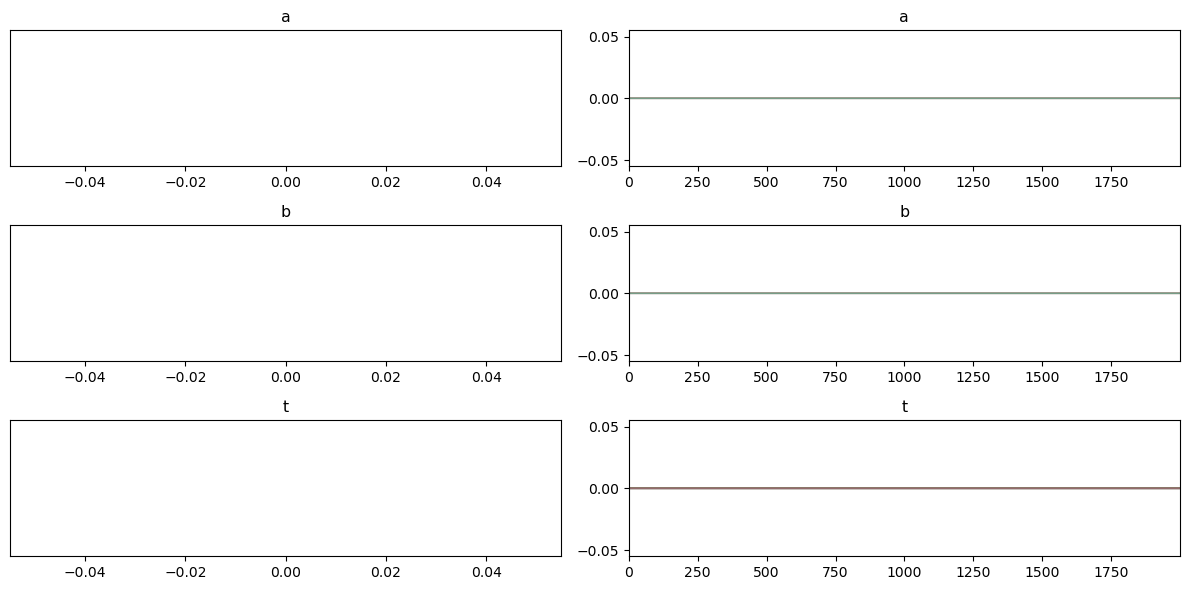

In [161]:
rng = np.random.default_rng(0)
P, I = 25, 10

# true parameters
true_a = rng.normal(0.5, 1.0, size=I)
true_b = rng.normal(0.0, 1.0, size=I)
true_theta = rng.normal(0.0, 1.0, size=P)

lin = np.outer(true_theta, true_a) + true_b[None, :]
prob = 1.0 / (1.0 + np.exp(-lin))
Y = (rng.uniform(size=(P, I)) < prob).astype(np.int32)

# create two different initializations for the two chains
a_init = (jnp.zeros(I), jnp.ones(I) * 2.0)
b_init = (jnp.zeros(I), jnp.ones(I) * -2.0)
t_init = (jnp.zeros(P), jnp.ones(P) * 1.5)

# run the coupled sampler
n_iter = 2000
D = 2*I + P

# create a random PSD covariance
A = np.random.randn(D, D)
prop_cov = jnp.array(A @ A.T + 1e-6*np.eye(D))  # ensure PSD

start_time = time()
traces, acc = mh_full_block_reflective_couple_single_accept(
    (Y, Y),
    n_iter=n_iter,
    prop_cov=prop_cov,
    a_init=a_init,
    b_init=b_init,
    t_init=t_init
)
end_time = time()

print(f"Coupled MH sampler runtime: {end_time - start_time:.2f} seconds\n")

# Single acceptance rate
print("Mean acceptance rate (joint block):", acc)

# Posterior means after burn-in (use chain 0 by default)
chain_idx = 0
a_tr = traces['a'][chain_idx]
b_tr = traces['b'][chain_idx]
t_tr = traces['t'][chain_idx]

a_hat = a_tr.mean(axis=0)
b_hat = b_tr.mean(axis=0)
theta_hat = t_tr.mean(axis=0)

print("\nPosterior means (first 5):")
print("a_hat[:5]:", a_hat[:5])
print("b_hat[:5]:", b_hat[:5])
print("theta_hat[:5]:", theta_hat[:5])

# Compare to truth
a_diff = a_hat - true_a
b_diff = b_hat - true_b
theta_diff = theta_hat - true_theta

print("\nDifferences (posterior mean - true value) first 5:")
print("a_diff[:5]:", a_diff[:5])
print("b_diff[:5]:", b_diff[:5])
print("theta_diff[:5]:", theta_diff[:5])

print("\nSummary of absolute differences:")
print("Mean abs error a:", np.mean(np.abs(a_diff)))
print("Mean abs error b:", np.mean(np.abs(b_diff)))
print("Mean abs error theta:", np.mean(np.abs(theta_diff)))
print("Max abs error a:", np.max(np.abs(a_diff)))
print("Max abs error b:", np.max(np.abs(b_diff)))
print("Max abs error theta:", np.max(np.abs(theta_diff)))

# --- Approximate meeting time (chains close enough) ---
tolerance = 1e-4
meeting_time = None

for it in range(n_iter):
    close_a = np.allclose(traces['a'][0, it, :], traces['a'][1, it, :], atol=tolerance)
    close_b = np.allclose(traces['b'][0, it, :], traces['b'][1, it, :], atol=tolerance)
    close_t = np.allclose(traces['t'][0, it, :], traces['t'][1, it, :], atol=tolerance)
    
    if close_a and close_b and close_t:
        meeting_time = it
        break

if meeting_time is not None:
    print(f"\nChains approximately met at iteration (0-based): {meeting_time}")
else:
    print("\nChains did NOT meet within the run (parameters not within tolerance).")

# Optional: ArviZ diagnostics / traceplot for chain 0
try:
    idata = az.from_dict(
        posterior={
            "a": traces['a'][chain_idx][None, :, :],  # shape (chain=1, draws, I)
            "b": traces['b'][chain_idx][None, :, :],
            "t": traces['t'][chain_idx][None, :, :],
        }
    )
    az.plot_trace(idata, var_names=["a", "b", "t"])
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("ArviZ plotting failed:", e)


### JIT Metropolis-Hastings

#### Parameter Blocked Metropolis-Hastings

In [190]:
# ------------------------
# Log joint
# ------------------------
def log_joint(a, b, t, Y, sa, sb):
    la = jnp.sum(norm.logpdf(a, 0., sa))
    lb = jnp.sum(norm.logpdf(b, 0., sb))
    lt = jnp.sum(norm.logpdf(t, 0., 1.))
    lin = jnp.outer(t, a) + b[None, :]
    lY = jnp.sum(Y * jnp.log(jax.nn.sigmoid(lin)) +
                 (1 - Y) * jnp.log(1 - jax.nn.sigmoid(lin)))
    return la + lb + lt + lY

# ------------------------
# Reflective coupling proposal
# ------------------------
def reflective_coupling_proposal(key, mu1, mu2, cov):
    L = jnp.linalg.cholesky(cov)
    Delta = mu1 - mu2
    norm_val = jnp.linalg.norm(Delta)
    e = jnp.where(norm_val > 0, Delta / norm_val, jnp.zeros_like(Delta))
    
    key, subkey = random.split(key)
    x = random.normal(subkey, shape=mu1.shape)
    
    key, subkey = random.split(key)
    log_u = jnp.log(random.uniform(subkey))
    
    log_ratio = jnp.sum(norm.logpdf(x + Delta, 0., 1.) - norm.logpdf(x, 0., 1.))
    
    y = lax.cond(log_u <= log_ratio,
                 lambda x: x + Delta,
                 lambda x: x - 2 * (e @ x) * e,
                 x)
    
    prop1 = mu1 + L @ x
    prop2 = mu2 + L @ y
    return key, prop1, prop2

# ------------------------
# MH block step
# ------------------------
def mh_block_step(key, x1, x2, joint1, joint2, prop_cov, clp1, clp2, acc1, acc2):
    key, prop1, prop2 = reflective_coupling_proposal(key, x1, x2, prop_cov)
    lp1 = joint1(prop1)
    lp2 = joint2(prop2)
    
    log_alpha1 = lp1 - clp1
    log_alpha2 = lp2 - clp2
    
    key, subkey = random.split(key)
    log_u = jnp.log(random.uniform(subkey))
    
    x1, clp1, acc1 = lax.cond(log_u < log_alpha1,
                              lambda _: (prop1, lp1, acc1 + 1),
                              lambda _: (x1, clp1, acc1),
                              operand=None)
    x2, clp2, acc2 = lax.cond(log_u < log_alpha2,
                              lambda _: (prop2, lp2, acc2 + 1),
                              lambda _: (x2, clp2, acc2),
                              operand=None)
    return key, x1, x2, clp1, clp2, acc1, acc2

# ------------------------
# Inner scan
# ------------------------
def mh_block_reflective_scan(Y1, Y2, a_init, b_init, t_init, n_iter,
                             prop_cov_a, prop_cov_b, prop_cov_t, sa, sb):
    a1, a2 = a_init
    b1, b2 = b_init
    t1, t2 = t_init
    
    clp1 = log_joint(a1, b1, t1, Y1, sa, sb)
    clp2 = log_joint(a2, b2, t2, Y2, sa, sb)
    
    acc_a1 = acc_a2 = acc_b1 = acc_b2 = acc_t1 = acc_t2 = 0
    key = random.PRNGKey(0)
    
    def body(carry, _):
        key, a1, a2, b1, b2, t1, t2, clp1, clp2, acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2 = carry
        
        key, a1, a2, clp1, clp2, acc_a1, acc_a2 = mh_block_step(
            key, a1, a2,
            lambda x: log_joint(x, b1, t1, Y1, sa, sb),
            lambda x: log_joint(x, b2, t2, Y2, sa, sb),
            prop_cov_a, clp1, clp2, acc_a1, acc_a2
        )
        key, b1, b2, clp1, clp2, acc_b1, acc_b2 = mh_block_step(
            key, b1, b2,
            lambda x: log_joint(a1, x, t1, Y1, sa, sb),
            lambda x: log_joint(a2, x, t2, Y2, sa, sb),
            prop_cov_b, clp1, clp2, acc_b1, acc_b2
        )
        key, t1, t2, clp1, clp2, acc_t1, acc_t2 = mh_block_step(
            key, t1, t2,
            lambda x: log_joint(a1, b1, x, Y1, sa, sb),
            lambda x: log_joint(a2, b2, x, Y2, sa, sb),
            prop_cov_t, clp1, clp2, acc_t1, acc_t2
        )
        
        carry = (key, a1, a2, b1, b2, t1, t2, clp1, clp2,
                 acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2)
        trace = (a1, a2, b1, b2, t1, t2)
        return carry, trace
    
    carry_init = (key, a1, a2, b1, b2, t1, t2, clp1, clp2,
                  acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2)
    
    carry_final, traces = lax.scan(body, carry_init, None, length=n_iter)
    
    traces_dict = {
        'a': jnp.stack([traces[0], traces[1]], axis=0),
        'b': jnp.stack([traces[2], traces[3]], axis=0),
        't': jnp.stack([traces[4], traces[5]], axis=0)
    }
    
    acc_rates = {
        'a': (carry_final[9]/n_iter, carry_final[10]/n_iter),
        'b': (carry_final[11]/n_iter, carry_final[12]/n_iter),
        't': (carry_final[13]/n_iter, carry_final[14]/n_iter)
    }
    
    return traces_dict, acc_rates


Coupled MH sampler runtime: 0.76 seconds


Posterior means (first 5):
a_hat[:5]: [2.072138   1.009352   4.4607387  0.17558715 0.29218647]
b_hat[:5]: [-2.2631824  -0.22030629 -5.3630753  -0.89367175 -1.3344945 ]
theta_hat[:5]: [-0.03494897  0.41483086 -0.21728416  0.09088691 -0.0886377 ]

Summary of absolute differences:
Mean abs error a: 0.8642936
Mean abs error b: 0.8025888
Mean abs error theta: 0.5358618

Chains approximately met at iteration (0-based): 153491

Posterior means (first 5) after meeting:
a_hat[:5]: [2.7268703  1.3191003  5.736409   0.30985984 0.40160057]
b_hat[:5]: [-2.3791933  -0.2310662  -5.6724634  -0.89013344 -1.3329793 ]
theta_hat[:5]: [-0.04966131  0.64241546 -0.32180852  0.13306934 -0.09662376]

Differences (posterior mean - true value) first 5:
a_diff[:5]: [ 2.10114     0.95120513  4.5959864  -0.29504028  0.43726993]
b_diff[:5]: [-1.7559189  -0.27239218 -3.3474326  -0.6713418  -0.08706832]
theta_diff[:5]: [ 0.07887335 -0.72404796  0.34338617 -0.21844074 -1.00009

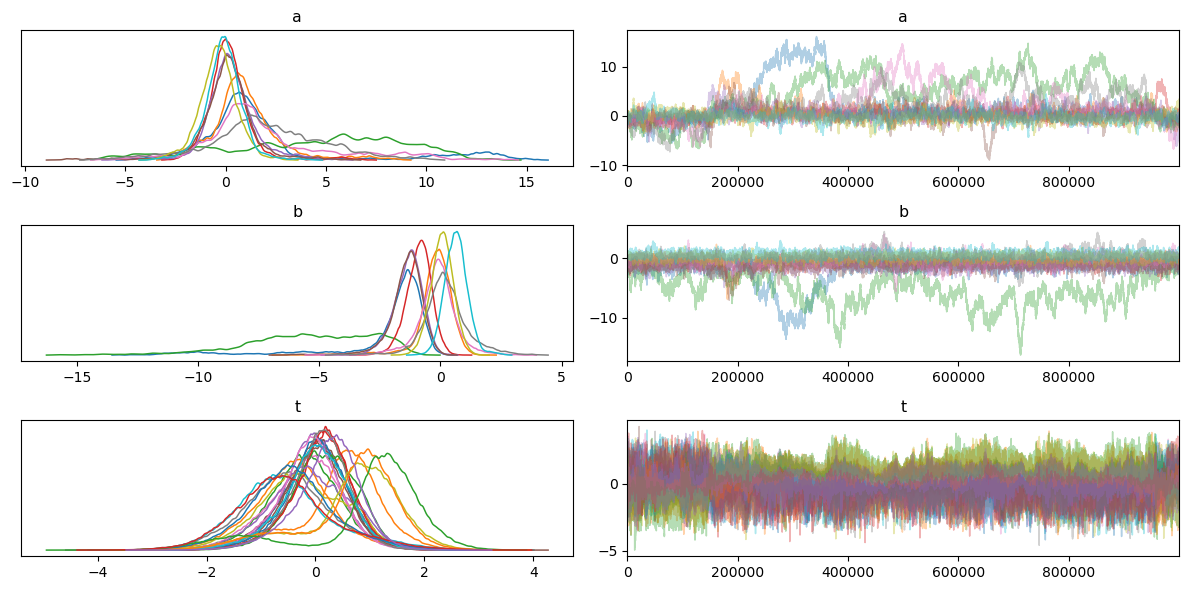

In [191]:
# ------------------------
# Model settings
# ------------------------
variance = 100.0
sa = jnp.sqrt(variance)
sb = jnp.sqrt(variance)

rng = np.random.default_rng(0)
P, I = 25, 10

true_a = rng.normal(0.5, 1.0, size=I)
true_b = rng.normal(0.0, 1.0, size=I)
true_theta = rng.normal(0.0, 1.0, size=P)

lin = np.outer(true_theta, true_a) + true_b[None, :]
prob = 1.0 / (1.0 + np.exp(-lin))
Y = (rng.uniform(size=(P, I)) < prob).astype(np.int32)

# ------------------------
# Initializations
# ------------------------
a_init = (jnp.zeros(I), jnp.ones(I) * 2.0)
b_init = (jnp.zeros(I), jnp.ones(I) * -2.0)
t_init = (jnp.zeros(P), jnp.ones(P) * 1.5)

prop_sd_a = 0.03
prop_sd_b = 0.03
prop_sd_t = 0.18

# Precompute covariances outside JIT
prop_cov_a = prop_sd_a**2 * jnp.eye(I)
prop_cov_b = prop_sd_b**2 * jnp.eye(I)
prop_cov_t = prop_sd_t**2 * jnp.eye(P)

n_iter = 1000000

# ------------------------
# Run sampler
# ------------------------
start_time = time()
traces, acc = mh_block_reflective_scan(
    Y, Y, a_init, b_init, t_init, n_iter,
    prop_cov_a, prop_cov_b, prop_cov_t,
    sa, sb
)
end_time = time()

print(f"Coupled MH sampler runtime: {end_time - start_time:.2f} seconds\n")

# ------------------------
# Posterior summaries
# ------------------------
chain_idx = 0
a_tr = traces['a'][chain_idx]
b_tr = traces['b'][chain_idx]
t_tr = traces['t'][chain_idx]

a_hat = a_tr.mean(axis=0)
b_hat = b_tr.mean(axis=0)
theta_hat = t_tr.mean(axis=0)

print("\nPosterior means (first 5):")
print("a_hat[:5]:", a_hat[:5])
print("b_hat[:5]:", b_hat[:5])
print("theta_hat[:5]:", theta_hat[:5])

# ------------------------
# Compare to truth
# ------------------------
a_diff = a_hat - true_a
b_diff = b_hat - true_b
theta_diff = theta_hat - true_theta

print("\nSummary of absolute differences:")
print("Mean abs error a:", np.mean(np.abs(a_diff)))
print("Mean abs error b:", np.mean(np.abs(b_diff)))
print("Mean abs error theta:", np.mean(np.abs(theta_diff)))

# --- Approximate meeting time (chains close enough) ---
tolerance = 1e-4
meeting_time = None

for it in range(n_iter):
    close_a = np.allclose(traces['a'][0, it, :], traces['a'][1, it, :], atol=tolerance)
    close_b = np.allclose(traces['b'][0, it, :], traces['b'][1, it, :], atol=tolerance)
    close_t = np.allclose(traces['t'][0, it, :], traces['t'][1, it, :], atol=tolerance)
    
    if close_a and close_b and close_t:
        meeting_time = it
        break

if meeting_time is not None:
    print(f"\nChains approximately met at iteration (0-based): {meeting_time}")
    
    # --- Safe slicing: ensure arrays are not empty ---
    post_meeting_slice = slice(meeting_time, None)
    
    # Posterior means after meeting (chain 0)
    chain_idx = 0
    a_tr = traces['a'][chain_idx][post_meeting_slice]
    b_tr = traces['b'][chain_idx][post_meeting_slice]
    t_tr = traces['t'][chain_idx][post_meeting_slice]

    # Posterior summaries
    a_hat = a_tr.mean(axis=0)
    b_hat = b_tr.mean(axis=0)
    theta_hat = t_tr.mean(axis=0)
    
    print("\nPosterior means (first 5) after meeting:")
    print("a_hat[:5]:", a_hat[:5])
    print("b_hat[:5]:", b_hat[:5])
    print("theta_hat[:5]:", theta_hat[:5])
    
    # Compare to truth
    a_diff = a_hat - true_a
    b_diff = b_hat - true_b
    theta_diff = theta_hat - true_theta
    
    print("\nDifferences (posterior mean - true value) first 5:")
    print("a_diff[:5]:", a_diff[:5])
    print("b_diff[:5]:", b_diff[:5])
    print("theta_diff[:5]:", theta_diff[:5])
    
    print("\nSummary of absolute differences:")
    print("Mean abs error a:", np.mean(np.abs(a_diff)))
    print("Mean abs error b:", np.mean(np.abs(b_diff)))
    print("Mean abs error theta:", np.mean(np.abs(theta_diff)))
    print("Max abs error a:", np.max(np.abs(a_diff)))
    print("Max abs error b:", np.max(np.abs(b_diff)))
    print("Max abs error theta:", np.max(np.abs(theta_diff)))

    # --- Acceptance rates ---
    # If your acc arrays are per-iteration, per-parameter:
    if isinstance(acc['a'][0], np.ndarray) and acc['a'][0].size >= meeting_time:
        print("\nMean acceptance rates after meeting (chain 0):")
        print(" mean acc a:", np.mean(acc['a'][0][post_meeting_slice]))
        print(" mean acc b:", np.mean(acc['b'][0][post_meeting_slice]))
        print(" mean acc t:", np.mean(acc['t'][0][post_meeting_slice]))
        print("\nMean acceptance rates after meeting (chain 1):")
        print(" mean acc a:", np.mean(acc['a'][1][post_meeting_slice]))
        print(" mean acc b:", np.mean(acc['b'][1][post_meeting_slice]))
        print(" mean acc t:", np.mean(acc['t'][1][post_meeting_slice]))
    else:
        print("\nAcceptance arrays not long enough; showing total acceptance rates instead:")
        print("acc (chain0):", {k: np.mean(v[0]) for k,v in acc.items()})
        print("acc (chain1):", {k: np.mean(v[1]) for k,v in acc.items()})
    
else:
    print("\nChains did NOT meet within the run (parameters not within tolerance).")


# ------------------------
# Optional traceplots
# ------------------------
try:
    idata = az.from_dict(
        posterior={
            "a": traces['a'][chain_idx][None, :, :],
            "b": traces['b'][chain_idx][None, :, :],
            "t": traces['t'][chain_idx][None, :, :]
        }
    )
    az.plot_trace(idata, var_names=["a", "b", "t"])
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("ArviZ plotting failed:", e)


#### Fully Blocked Metropolis-Hastings

In [192]:
# ------------------------
# Log joint using numpyro
# ------------------------
def log_joint(a, b, t, Y, sa=10.0, sb=10.0):
    la = jnp.sum(dist.Normal(0., sa).log_prob(a))
    lb = jnp.sum(dist.Normal(0., sb).log_prob(b))
    lt = jnp.sum(dist.Normal(0., 1.).log_prob(t))

    pi_val = jnp.outer(t, a) + b[None, :]
    lY = jnp.sum(dist.Bernoulli(logits=pi_val).log_prob(Y))
    return la + lb + lt + lY

# ------------------------
# Reflective coupling proposal
# ------------------------
def reflective_coupling_proposal(key, mu1, mu2, cov):
    L = jnp.linalg.cholesky(cov)
    Delta = mu1 - mu2
    e = Delta / (jnp.linalg.norm(Delta) + 1e-16)

    key, subkey = random.split(key)
    x = random.normal(subkey, shape=mu1.shape)

    key, subkey = random.split(key)
    log_u = jnp.log(random.uniform(subkey))

    # log ratio for maximal reflection
    logpdf = lambda x: -0.5 * x**2 - 0.5 * jnp.log(2*jnp.pi)
    log_ratio = jnp.sum(logpdf(x + Delta) - logpdf(x))

    y = lax.cond(
        log_u <= log_ratio,
        lambda x: x + Delta,
        lambda x: x - 2 * (e @ x) * e,
        x
    )

    prop1 = mu1 + L @ x
    prop2 = mu2 + L @ y
    return key, prop1, prop2

# ------------------------
# MH block step
# ------------------------
def mh_block_step_reflective_couple(key, x1, x2, joint1, joint2, prop_cov, clp1, clp2, acc):
    key, prop1, prop2 = reflective_coupling_proposal(key, x1, x2, prop_cov)

    lp_prop1 = joint1(prop1)
    lp_prop2 = joint2(prop2)

    log_alpha1 = lp_prop1 - clp1
    log_alpha2 = lp_prop2 - clp2

    key, subkey = random.split(key)
    log_u = jnp.log(random.uniform(subkey))

    accept1 = log_u < log_alpha1
    accept2 = log_u < log_alpha2

    x1 = jnp.where(accept1, prop1, x1)
    x2 = jnp.where(accept2, prop2, x2)
    clp1 = jnp.where(accept1, lp_prop1, clp1)
    clp2 = jnp.where(accept2, lp_prop2, clp2)
    acc += accept1.astype(jnp.int32) + accept2.astype(jnp.int32)

    return key, x1, x2, clp1, clp2, acc

# ------------------------
# Full block reflective coupled sampler (single accept)
# ------------------------
def mh_full_block_reflective_couple_single_accept(Y, n_iter=2000, prop_cov=None, a_init=None, b_init=None, t_init=None, sa=10., sb=10.):
    Y1 = jnp.asarray(Y[0])
    Y2 = jnp.asarray(Y[1])
    P, I = Y1.shape

    # initialize chains
    a1, a2 = (jnp.zeros(I), jnp.zeros(I)) if a_init is None else a_init
    b1, b2 = (jnp.zeros(I), jnp.zeros(I)) if b_init is None else b_init
    t1, t2 = (jnp.zeros(P), jnp.zeros(P)) if t_init is None else t_init

    D = 2*I + P
    if prop_cov is None:
        prop_cov = jnp.eye(D) * 0.01

    key = random.PRNGKey(0)
    curr_lp1 = log_joint(a1, b1, t1, Y1, sa, sb)
    curr_lp2 = log_joint(a2, b2, t2, Y2, sa, sb)
    acc = 0

    params = jnp.concatenate([a1, b1, t1, a2, b2, t2])

    def step(carry, _):
        key, params, curr_lp1, curr_lp2, acc = carry
        a1, b1, t1 = params[:I], params[I:2*I], params[2*I:2*I+P]
        a2, b2, t2 = params[2*I+P:2*I+P+I], params[2*I+P+I:2*I+P+2*I], params[2*I+P+2*I:]

        joint1 = lambda x: log_joint(x[:I], x[I:2*I], x[2*I:], Y1, sa, sb)
        joint2 = lambda x: log_joint(x[:I], x[I:2*I], x[2*I:], Y2, sa, sb)

        key, params1, params2, curr_lp1, curr_lp2, acc = mh_block_step_reflective_couple(
            key,
            jnp.concatenate([a1,b1,t1]),
            jnp.concatenate([a2,b2,t2]),
            joint1,
            joint2,
            prop_cov,
            curr_lp1,
            curr_lp2,
            acc
        )

        new_params = jnp.concatenate([params1, params2])
        return (key, new_params, curr_lp1, curr_lp2, acc), new_params

    carry = (key, params, curr_lp1, curr_lp2, acc)
    carry, trace_all = lax.scan(step, carry, None, length=n_iter)

    trace_all = trace_all.T
    trace_a = np.array(trace_all[:I*2, :].reshape(2, n_iter, I))
    trace_b = np.array(trace_all[I*2:I*4, :].reshape(2, n_iter, I))
    trace_t = np.array(trace_all[I*4:, :].reshape(2, n_iter, P))

    _, _, _, _, acc = carry
    traces = {'a': trace_a, 'b': trace_b, 't': trace_t}
    acc_rate = acc / n_iter
    return traces, acc_rate


##### Testing with independent proposals

Coupled MH sampler runtime: 24.49 seconds
Mean acceptance rate (joint block): 0.418363

Posterior means (first 5):
a_hat[:5]: [1.9371122 1.9370959 1.9370891 1.9370848 1.9371073]
b_hat[:5]: [-0.14541954 -0.14533272 -0.14527908 -0.14515689 -0.14519432]
theta_hat[:5]: [0.40429828 0.40430224 0.4042906  0.40427902 0.4042502 ]

Summary of absolute differences:
Mean abs error a: 1.3524292065168193
Mean abs error b: 0.6920302319868716
Mean abs error theta: 0.6881958282110223
Max abs error a: 2.702540835784517
Max abs error b: 2.17975169496316
Max abs error theta: 1.6632372075477695

Chains did NOT meet within the run (parameters not within tolerance).


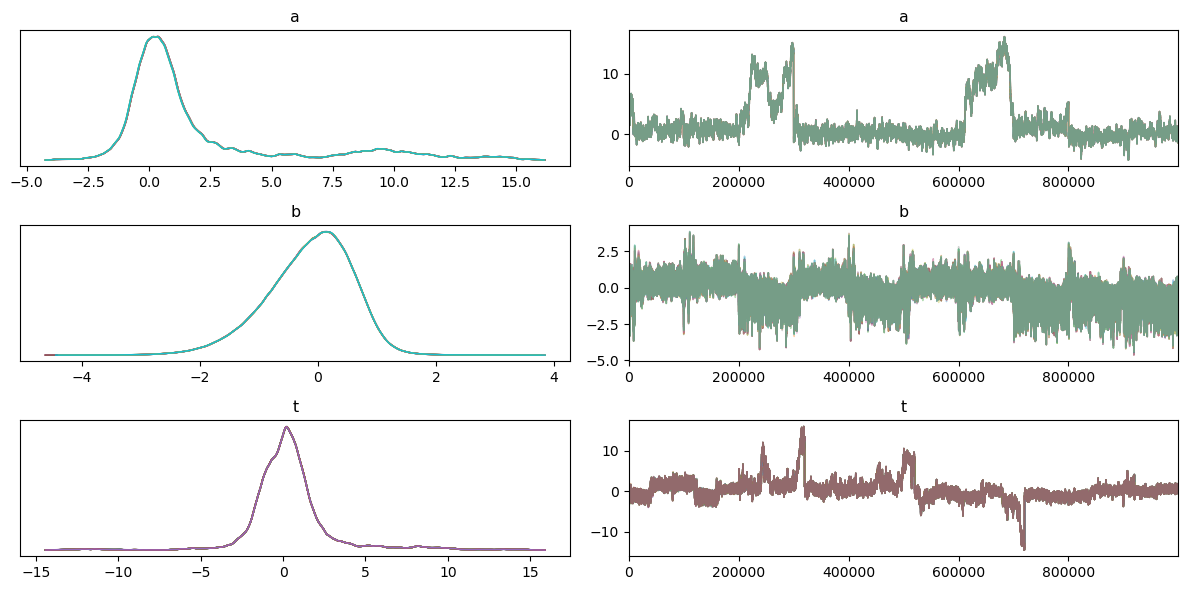

In [193]:
rng = np.random.default_rng(0)
P, I = 25, 10

# true parameters
true_a = rng.normal(0.5, 1.0, size=I)
true_b = rng.normal(0.0, 1.0, size=I)
true_theta = rng.normal(0.0, 1.0, size=P)

lin = np.outer(true_theta, true_a) + true_b[None, :]
prob = 1.0 / (1.0 + np.exp(-lin))
Y = (rng.uniform(size=(P, I)) < prob).astype(np.int32)

# initializations for the two chains
a_init = (jnp.zeros(I), jnp.ones(I) * 2.0)
b_init = (jnp.zeros(I), jnp.ones(I) * -2.0)
t_init = (jnp.zeros(P), jnp.ones(P) * 1.5)

# proposal covariance
prop_sd_a = 0.03
prop_sd_b = 0.03
prop_sd_t = 0.18
prop_cov = jnp.diag(jnp.concatenate([
    prop_sd_a**2 * jnp.ones(I),
    prop_sd_b**2 * jnp.ones(I),
    prop_sd_t**2 * jnp.ones(P)
]))

n_iter = 1000000

# ------------------------
# Run sampler
# ------------------------
start_time = time()
traces, acc = mh_full_block_reflective_couple_single_accept(
    (Y, Y),
    n_iter=n_iter,
    prop_cov=prop_cov,
    a_init=a_init,
    b_init=b_init,
    t_init=t_init
)
end_time = time()
print(f"Coupled MH sampler runtime: {end_time - start_time:.2f} seconds")
print("Mean acceptance rate (joint block):", acc)

# ------------------------
# Posterior means
# ------------------------
chain_idx = 0
a_tr = traces['a'][chain_idx]
b_tr = traces['b'][chain_idx]
t_tr = traces['t'][chain_idx]

a_hat = a_tr.mean(axis=0)
b_hat = b_tr.mean(axis=0)
theta_hat = t_tr.mean(axis=0)

print("\nPosterior means (first 5):")
print("a_hat[:5]:", a_hat[:5])
print("b_hat[:5]:", b_hat[:5])
print("theta_hat[:5]:", theta_hat[:5])

# ------------------------
# Compare to truth
# ------------------------
a_diff = a_hat - true_a
b_diff = b_hat - true_b
theta_diff = theta_hat - true_theta

print("\nSummary of absolute differences:")
print("Mean abs error a:", np.mean(np.abs(a_diff)))
print("Mean abs error b:", np.mean(np.abs(b_diff)))
print("Mean abs error theta:", np.mean(np.abs(theta_diff)))
print("Max abs error a:", np.max(np.abs(a_diff)))
print("Max abs error b:", np.max(np.abs(b_diff)))
print("Max abs error theta:", np.max(np.abs(theta_diff)))

# --- Approximate meeting time (chains close enough) ---
tolerance = 1e-4
meeting_time = None

for it in range(n_iter):
    close_a = np.allclose(traces['a'][0, it, :], traces['a'][1, it, :], atol=tolerance)
    close_b = np.allclose(traces['b'][0, it, :], traces['b'][1, it, :], atol=tolerance)
    close_t = np.allclose(traces['t'][0, it, :], traces['t'][1, it, :], atol=tolerance)
    
    if close_a and close_b and close_t:
        meeting_time = it
        break

if meeting_time is not None:
    print(f"\nChains approximately met at iteration (0-based): {meeting_time}")
    
    # --- Safe slicing: ensure arrays are not empty ---
    post_meeting_slice = slice(meeting_time, None)
    
    # Posterior means after meeting (chain 0)
    chain_idx = 0
    a_tr = traces['a'][chain_idx][post_meeting_slice]
    b_tr = traces['b'][chain_idx][post_meeting_slice]
    t_tr = traces['t'][chain_idx][post_meeting_slice]

    # Posterior summaries
    a_hat = a_tr.mean(axis=0)
    b_hat = b_tr.mean(axis=0)
    theta_hat = t_tr.mean(axis=0)
    
    print("\nPosterior means (first 5) after meeting:")
    print("a_hat[:5]:", a_hat[:5])
    print("b_hat[:5]:", b_hat[:5])
    print("theta_hat[:5]:", theta_hat[:5])
    
    # Compare to truth
    a_diff = a_hat - true_a
    b_diff = b_hat - true_b
    theta_diff = theta_hat - true_theta
    
    print("\nDifferences (posterior mean - true value) first 5:")
    print("a_diff[:5]:", a_diff[:5])
    print("b_diff[:5]:", b_diff[:5])
    print("theta_diff[:5]:", theta_diff[:5])
    
    print("\nSummary of absolute differences:")
    print("Mean abs error a:", np.mean(np.abs(a_diff)))
    print("Mean abs error b:", np.mean(np.abs(b_diff)))
    print("Mean abs error theta:", np.mean(np.abs(theta_diff)))
    print("Max abs error a:", np.max(np.abs(a_diff)))
    print("Max abs error b:", np.max(np.abs(b_diff)))
    print("Max abs error theta:", np.max(np.abs(theta_diff)))

    # --- Acceptance rates ---
    # If your acc arrays are per-iteration, per-parameter:
    if isinstance(acc['a'][0], np.ndarray) and acc['a'][0].size >= meeting_time:
        print("\nMean acceptance rates after meeting (chain 0):")
        print(" mean acc a:", np.mean(acc['a'][0][post_meeting_slice]))
        print(" mean acc b:", np.mean(acc['b'][0][post_meeting_slice]))
        print(" mean acc t:", np.mean(acc['t'][0][post_meeting_slice]))
        print("\nMean acceptance rates after meeting (chain 1):")
        print(" mean acc a:", np.mean(acc['a'][1][post_meeting_slice]))
        print(" mean acc b:", np.mean(acc['b'][1][post_meeting_slice]))
        print(" mean acc t:", np.mean(acc['t'][1][post_meeting_slice]))
    else:
        print("\nAcceptance arrays not long enough; showing total acceptance rates instead:")
        print("acc (chain0):", {k: np.mean(v[0]) for k,v in acc.items()})
        print("acc (chain1):", {k: np.mean(v[1]) for k,v in acc.items()})
    
else:
    print("\nChains did NOT meet within the run (parameters not within tolerance).")

# ------------------------
# Optional ArviZ plot
# ------------------------
try:
    idata = az.from_dict(
        posterior={
            "a": traces['a'][chain_idx][None, :, :],
            "b": traces['b'][chain_idx][None, :, :],
            "t": traces['t'][chain_idx][None, :, :]
        }
    )
    az.plot_trace(idata, var_names=["a","b","t"])
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("ArviZ plotting failed:", e)


##### Testing with covariant proposals

Coupled MH sampler runtime: 24.80 seconds

Mean acceptance rate (joint block): 0.0

Posterior means (first 5):
a_hat[:5]: [0. 0. 0. 0. 0.]
b_hat[:5]: [0. 0. 0. 0. 0.]
theta_hat[:5]: [0. 0. 0. 0. 0.]

Differences (posterior mean - true value) first 5:
a_diff[:5]: [-0.62573022 -0.36789514 -1.14042265 -0.60490012  0.03566937]
b_diff[:5]: [ 0.62327446 -0.04132598  2.32503077  0.21879166  1.24591095]
theta_diff[:5]: [ 0.12853466 -1.36646347  0.66519467 -0.35151007 -0.90347018]

Summary of absolute differences:
Mean abs error a: 0.7856450268581434
Mean abs error b: 0.7501304227455768
Mean abs error theta: 0.6626683094336429
Max abs error a: 1.8040000451301372
Max abs error b: 2.3250307746388343
Max abs error theta: 1.5139237747390626

Chains did NOT meet within the run (parameters not within tolerance).


/opt/anaconda3/envs/UnbiasedMCMC/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/anaconda3/envs/UnbiasedMCMC/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


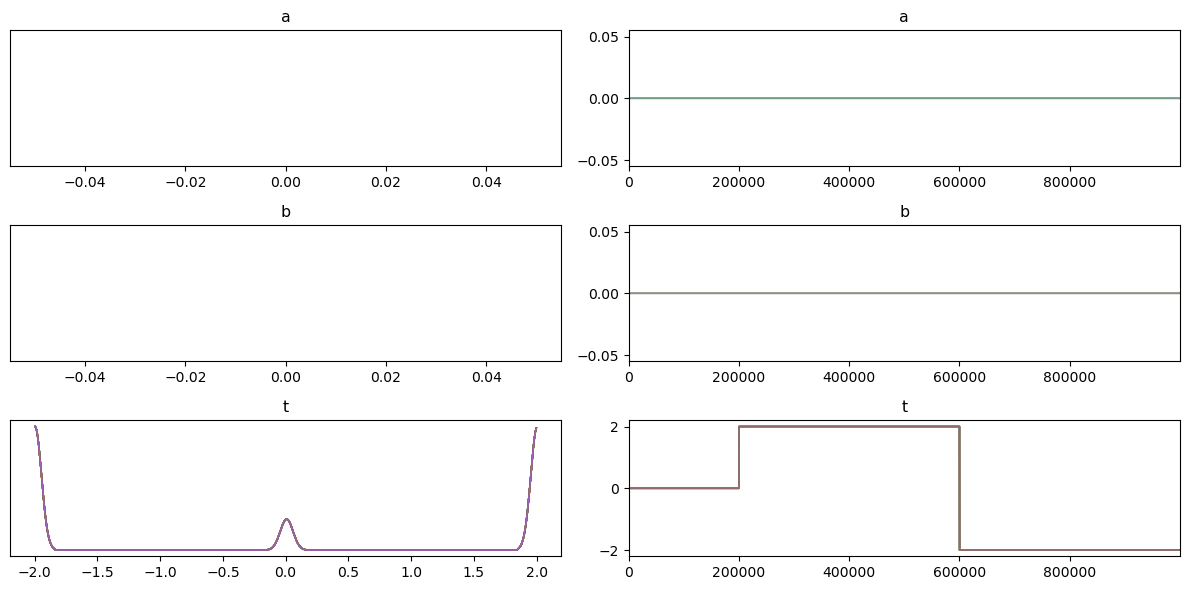

In [194]:
rng = np.random.default_rng(0)
P, I = 25, 10

# true parameters
true_a = rng.normal(0.5, 1.0, size=I)
true_b = rng.normal(0.0, 1.0, size=I)
true_theta = rng.normal(0.0, 1.0, size=P)

lin = np.outer(true_theta, true_a) + true_b[None, :]
prob = 1.0 / (1.0 + np.exp(-lin))
Y = (rng.uniform(size=(P, I)) < prob).astype(np.int32)

# create two different initializations for the two chains
a_init = (jnp.zeros(I), jnp.ones(I) * 2.0)
b_init = (jnp.zeros(I), jnp.ones(I) * -2.0)
t_init = (jnp.zeros(P), jnp.ones(P) * 1.5)

# run the coupled sampler
n_iter = 1000000
D = 2*I + P

# create a random PSD covariance
A = np.random.randn(D, D)
prop_cov = jnp.array(A @ A.T + 1e-6*np.eye(D))  # ensure PSD

start_time = time()
traces, acc = mh_full_block_reflective_couple_single_accept(
    (Y, Y),
    n_iter=n_iter,
    prop_cov=prop_cov,
    a_init=a_init,
    b_init=b_init,
    t_init=t_init
)
end_time = time()

print(f"Coupled MH sampler runtime: {end_time - start_time:.2f} seconds\n")

# Single acceptance rate
print("Mean acceptance rate (joint block):", acc)

# Posterior means after burn-in (use chain 0 by default)
chain_idx = 0
a_tr = traces['a'][chain_idx]
b_tr = traces['b'][chain_idx]
t_tr = traces['t'][chain_idx]

a_hat = a_tr.mean(axis=0)
b_hat = b_tr.mean(axis=0)
theta_hat = t_tr.mean(axis=0)

print("\nPosterior means (first 5):")
print("a_hat[:5]:", a_hat[:5])
print("b_hat[:5]:", b_hat[:5])
print("theta_hat[:5]:", theta_hat[:5])

# Compare to truth
a_diff = a_hat - true_a
b_diff = b_hat - true_b
theta_diff = theta_hat - true_theta

print("\nDifferences (posterior mean - true value) first 5:")
print("a_diff[:5]:", a_diff[:5])
print("b_diff[:5]:", b_diff[:5])
print("theta_diff[:5]:", theta_diff[:5])

print("\nSummary of absolute differences:")
print("Mean abs error a:", np.mean(np.abs(a_diff)))
print("Mean abs error b:", np.mean(np.abs(b_diff)))
print("Mean abs error theta:", np.mean(np.abs(theta_diff)))
print("Max abs error a:", np.max(np.abs(a_diff)))
print("Max abs error b:", np.max(np.abs(b_diff)))
print("Max abs error theta:", np.max(np.abs(theta_diff)))

# --- Approximate meeting time (chains close enough) ---
tolerance = 1e-4
meeting_time = None

for it in range(n_iter):
    close_a = np.allclose(traces['a'][0, it, :], traces['a'][1, it, :], atol=tolerance)
    close_b = np.allclose(traces['b'][0, it, :], traces['b'][1, it, :], atol=tolerance)
    close_t = np.allclose(traces['t'][0, it, :], traces['t'][1, it, :], atol=tolerance)
    
    if close_a and close_b and close_t:
        meeting_time = it
        break

if meeting_time is not None:
    print(f"\nChains approximately met at iteration (0-based): {meeting_time}")
    
    # --- Safe slicing: ensure arrays are not empty ---
    post_meeting_slice = slice(meeting_time, None)
    
    # Posterior means after meeting (chain 0)
    chain_idx = 0
    a_tr = traces['a'][chain_idx][post_meeting_slice]
    b_tr = traces['b'][chain_idx][post_meeting_slice]
    t_tr = traces['t'][chain_idx][post_meeting_slice]

    # Posterior summaries
    a_hat = a_tr.mean(axis=0)
    b_hat = b_tr.mean(axis=0)
    theta_hat = t_tr.mean(axis=0)
    
    print("\nPosterior means (first 5) after meeting:")
    print("a_hat[:5]:", a_hat[:5])
    print("b_hat[:5]:", b_hat[:5])
    print("theta_hat[:5]:", theta_hat[:5])
    
    # Compare to truth
    a_diff = a_hat - true_a
    b_diff = b_hat - true_b
    theta_diff = theta_hat - true_theta
    
    print("\nDifferences (posterior mean - true value) first 5:")
    print("a_diff[:5]:", a_diff[:5])
    print("b_diff[:5]:", b_diff[:5])
    print("theta_diff[:5]:", theta_diff[:5])
    
    print("\nSummary of absolute differences:")
    print("Mean abs error a:", np.mean(np.abs(a_diff)))
    print("Mean abs error b:", np.mean(np.abs(b_diff)))
    print("Mean abs error theta:", np.mean(np.abs(theta_diff)))
    print("Max abs error a:", np.max(np.abs(a_diff)))
    print("Max abs error b:", np.max(np.abs(b_diff)))
    print("Max abs error theta:", np.max(np.abs(theta_diff)))

    # --- Acceptance rates ---
    # If your acc arrays are per-iteration, per-parameter:
    if isinstance(acc['a'][0], np.ndarray) and acc['a'][0].size >= meeting_time:
        print("\nMean acceptance rates after meeting (chain 0):")
        print(" mean acc a:", np.mean(acc['a'][0][post_meeting_slice]))
        print(" mean acc b:", np.mean(acc['b'][0][post_meeting_slice]))
        print(" mean acc t:", np.mean(acc['t'][0][post_meeting_slice]))
        print("\nMean acceptance rates after meeting (chain 1):")
        print(" mean acc a:", np.mean(acc['a'][1][post_meeting_slice]))
        print(" mean acc b:", np.mean(acc['b'][1][post_meeting_slice]))
        print(" mean acc t:", np.mean(acc['t'][1][post_meeting_slice]))
    else:
        print("\nAcceptance arrays not long enough; showing total acceptance rates instead:")
        print("acc (chain0):", {k: np.mean(v[0]) for k,v in acc.items()})
        print("acc (chain1):", {k: np.mean(v[1]) for k,v in acc.items()})
    
else:
    print("\nChains did NOT meet within the run (parameters not within tolerance).")


# Optional: ArviZ diagnostics / traceplot for chain 0
try:
    idata = az.from_dict(
        posterior={
            "a": traces['a'][chain_idx][None, :, :],  # shape (chain=1, draws, I)
            "b": traces['b'][chain_idx][None, :, :],
            "t": traces['t'][chain_idx][None, :, :],
        }
    )
    az.plot_trace(idata, var_names=["a", "b", "t"])
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("ArviZ plotting failed:", e)
